#   Data loading and cleaning start


In [ ]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import pprint
from uszipcode import SearchEngine
from config import api_key
from census import Census

In [13]:
# Read in data from csv file
crime_df = pd.read_csv("chicago_crimes_all_cleaned.csv")

# Remove District 31 as it has a very low count
crime_df = crime_df[crime_df["District"] != 31]
crime_df = crime_df[["Case Number", "Date", "Block", "Primary Type", "Description", "District", "Ward",
                                     "Year", "Latitude", "Longitude", "Location", "Population", "Zipcode"]]
crime_df

,Case Number,Date,Block,Primary Type,Description,District,Ward,Year,Latitude,Longitude,Location,Population,Zipcode
0,JC104662,12/31/2018 11:59:00 PM,112XX S SACRAMENTO AVE,MINOR PROPERTY CRIME,TO VEHICLE,22,19.0,2018,41.689079,-87.696064,"(41.689078832, -87.696064026)",28804.0,60655.0
1,JC100043,12/31/2018 11:57:00 PM,084XX S SANGAMON ST,MINOR PROPERTY CRIME,TO PROPERTY,6,21.0,2018,41.740521,-87.647391,"(41.740520866, -87.647390719)",68096.0,60620.0
2,JC100006,12/31/2018 11:56:00 PM,018XX S ALLPORT ST,ASSAULT & BATTERY,AGG: HANDS/FIST/FEET NO/MINOR INJURY,12,25.0,2018,41.857068,-87.657625,"(41.857068095, -87.657625201)",79205.0,60608.0
3,JC100031,12/31/2018 11:55:00 PM,078XX S SANGAMON ST,ASSAULT & BATTERY,DOMESTIC BATTERY SIMPLE,6,17.0,2018,41.751914,-87.647717,"(41.75191443, -87.647716532)",68096.0,60620.0
4,JC100026,12/31/2018 11:49:00 PM,052XX W GLADYS AVE,ASSAULT & BATTERY,AGGRAVATED - HANDGUN,15,29.0,2018,41.875684,-87.760479,"(41.87568438, -87.760479356)",47712.0,60644.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145665,JF420379,9/16/2022 13:48,026XX N NARRAGANSETT AVE,THEFT (ALL TYPES),RETAIL THEFT,25,36.0,2022,41.928077,-87.785606,"(41.928076536, -87.785606186)",41309.0,60707.0
1145666,JF420478,9/1/2022 5:00,005XX W SURF ST,OTHER MINOR CRIMES,HARASSMENT BY TELEPHONE,19,44.0,2022,41.934305,-87.641485,"(41.934304581, -87.641484982)",72113.0,60657.0
1145667,JF420319,7/8/2022 0:00,114XX S PRAIRIE AVE,THEFT (ALL TYPES),FRAUD OR CONFIDENCE GAME,5,9.0,2022,41.685544,-87.616813,"(41.685543881, -87.616812541)",64489.0,60628.0
1145668,JF420102,9/27/2022 11:00,023XX E 70TH ST,THEFT (ALL TYPES),OVER $500,3,5.0,2022,41.768068,-87.567453,"(41.768068052, -87.567452932)",48973.0,60649.0


In [14]:
# Create a SearchEngine object 
search = SearchEngine()

In [15]:
# Define a function to get zip code from latitude and longitude
def fill_zip_code(row):
    # Use uszipcode's search by coordinates function, and set a small radius since we're only looking at Chicago
    result = search.by_coordinates(row['Latitude'], row['Longitude'], radius = 5)
    # If the result of the search is not empty
    if result:
        # Return the first element (zipcode) 
        return result[0].zipcode
    else:
        # If the result doesn't have a zipcode to pull, don't return anything
        return None

In [ ]:
# Run the latitude and longitude through the function to get the zip code. Note: this takes an extremely long amount of time.
crime_df["Zipcode"] = crime_df.apply(fill_zip_code, axis=1)



In [16]:
# Check to make sure zip codes were filled
crime_df

,Case Number,Date,Block,Primary Type,Description,District,Ward,Year,Latitude,Longitude,Location,Population,Zipcode
0,JC104662,12/31/2018 11:59:00 PM,112XX S SACRAMENTO AVE,MINOR PROPERTY CRIME,TO VEHICLE,22,19.0,2018,41.689079,-87.696064,"(41.689078832, -87.696064026)",28804.0,60655.0
1,JC100043,12/31/2018 11:57:00 PM,084XX S SANGAMON ST,MINOR PROPERTY CRIME,TO PROPERTY,6,21.0,2018,41.740521,-87.647391,"(41.740520866, -87.647390719)",68096.0,60620.0
2,JC100006,12/31/2018 11:56:00 PM,018XX S ALLPORT ST,ASSAULT & BATTERY,AGG: HANDS/FIST/FEET NO/MINOR INJURY,12,25.0,2018,41.857068,-87.657625,"(41.857068095, -87.657625201)",79205.0,60608.0
3,JC100031,12/31/2018 11:55:00 PM,078XX S SANGAMON ST,ASSAULT & BATTERY,DOMESTIC BATTERY SIMPLE,6,17.0,2018,41.751914,-87.647717,"(41.75191443, -87.647716532)",68096.0,60620.0
4,JC100026,12/31/2018 11:49:00 PM,052XX W GLADYS AVE,ASSAULT & BATTERY,AGGRAVATED - HANDGUN,15,29.0,2018,41.875684,-87.760479,"(41.87568438, -87.760479356)",47712.0,60644.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145665,JF420379,9/16/2022 13:48,026XX N NARRAGANSETT AVE,THEFT (ALL TYPES),RETAIL THEFT,25,36.0,2022,41.928077,-87.785606,"(41.928076536, -87.785606186)",41309.0,60707.0
1145666,JF420478,9/1/2022 5:00,005XX W SURF ST,OTHER MINOR CRIMES,HARASSMENT BY TELEPHONE,19,44.0,2022,41.934305,-87.641485,"(41.934304581, -87.641484982)",72113.0,60657.0
1145667,JF420319,7/8/2022 0:00,114XX S PRAIRIE AVE,THEFT (ALL TYPES),FRAUD OR CONFIDENCE GAME,5,9.0,2022,41.685544,-87.616813,"(41.685543881, -87.616812541)",64489.0,60628.0
1145668,JF420102,9/27/2022 11:00,023XX E 70TH ST,THEFT (ALL TYPES),OVER $500,3,5.0,2022,41.768068,-87.567453,"(41.768068052, -87.567452932)",48973.0,60649.0


In [17]:
# Change Zip code from an object to a float for merging purposes
crime_df["Zipcode"] = crime_df["Zipcode"].astype(float)

In [ ]:
# Save the file to .csv
crime_df.to_csv("zip_codes_added.csv", index = False)

In [19]:
# Check the amount of null values in the zip code column
print(f"The number of null values is: {crime_df.isna().sum()}")

The number of null values is: Case Number     0
Date            0
Block           0
Primary Type    0
Description     0
District        0
Ward            0
Year            0
Latitude        0
Longitude       0
Location        0
Population      0
Zipcode         0
dtype: int64


In [6]:
# Read in "zip_codes_added" to not run the crime_df["Zipcode"] above again. **Run from here to save time**
crime_df = pd.read_csv("zip_codes_added.csv")

In [7]:
# Read in the census data for 2018-2021. Note that we will have to get the 2022 census popultation data from another source (the census API)
pop_counts = pd.read_csv("Chicago_Population_Counts.csv")
pop_counts

,Geography Type,Year,Zipcode,Population - Total,Population - Age 0-17,Population - Age 18-29,Population - Age 30-39,Population - Age 40-49,Population - Age 50-59,Population - Age 60-69,...,Population - Age 18+,Population - Age 65+,Population - Female,Population - Male,Population - Latinx,Population - Asian Non-Latinx,Population - Black Non-Latinx,Population - White Non-Latinx,Population - Other Race Non-Latinx,Record ID
0,ZIP Code,2018,60601,14675,820,4606,2792,2190,1333,1340,...,13855,2075,7484,7191,1274,NaN,NaN,9677,NaN,ZIP_Code-60601-2018
1,ZIP Code,2018,60602,1244,149,435,462,135,53,10,...,1095,5,551,693,81,NaN,NaN,788,NaN,ZIP_Code-60602-2018
2,ZIP Code,2018,60603,1174,56,561,101,97,197,97,...,1118,112,601,573,115,NaN,NaN,707,NaN,ZIP_Code-60603-2018
3,ZIP Code,2018,60604,782,38,303,104,51,101,130,...,744,93,413,369,34,NaN,NaN,479,NaN,ZIP_Code-60604-2018
4,ZIP Code,2018,60605,27519,2260,8103,6316,3567,3344,2455,...,25259,2569,14381,13138,1608,NaN,NaN,15781,NaN,ZIP_Code-60605-2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,Zip Code,2021,60626,50295,8007,11937,8965,6995,6738,4360,...,42288,5098,25318,24977,9694,2724.0,12646.0,23029,2202.0,ZIP_CODE-60626-2021
227,Zip Code,2021,60628,64489,13734,11638,7491,7593,9066,6930,...,50755,10940,34961,29528,2775,79.0,59168.0,1462,1005.0,ZIP_CODE-60628-2021
228,Zip Code,2021,60629,107487,29283,20690,13227,14954,11096,8187,...,78204,13746,53753,53734,79111,595.0,18878.0,7650,1253.0,ZIP_CODE-60629-2021
229,Zip Code,2021,60630,55591,11093,7053,8926,7337,7479,7975,...,44498,9658,27787,27804,14180,7122.0,1007.0,31325,1957.0,ZIP_CODE-60630-2021


In [9]:
# Check to see how many null values we have
pop_counts.isna().sum()

Geography Type                         0
Year                                   0
Zipcode                                0
Population - Total                     0
Population - Age 0-17                  0
Population - Age 18-29                 0
Population - Age 30-39                 0
Population - Age 40-49                 0
Population - Age 50-59                 0
Population - Age 60-69                 0
Population - Age 70-79                 0
Population - Age 80+                   0
Population - Age 0-4                   0
Population - Age 5-11                 59
Population - Age 12-17                59
Population - Age 5+                    0
Population - Age 18+                   0
Population - Age 65+                   0
Population - Female                    0
Population - Male                      0
Population - Latinx                    0
Population - Asian Non-Latinx         59
Population - Black Non-Latinx         59
Population - White Non-Latinx          0
Population - Oth

In [10]:
# Merge crime DataFrame with population counts by zipcode
merged_df = crime_df.merge(pop_counts, on = ["Zipcode", "Year"], how = "left")
merged_df

,Case Number,Date,Block,Primary Type,Description,District,Ward,Year,Latitude,Longitude,...,Population - Age 18+,Population - Age 65+,Population - Female,Population - Male,Population - Latinx,Population - Asian Non-Latinx,Population - Black Non-Latinx,Population - White Non-Latinx,Population - Other Race Non-Latinx,Record ID
0,JC104662,12/31/2018 11:59:00 PM,112XX S SACRAMENTO AVE,MINOR PROPERTY CRIME,TO VEHICLE,22,19.0,2018,41.689079,-87.696064,...,21789.0,3731.0,14928.0,13876.0,2390.0,NaN,NaN,23795.0,NaN,ZIP_Code-60655-2018
1,JC100043,12/31/2018 11:57:00 PM,084XX S SANGAMON ST,MINOR PROPERTY CRIME,TO PROPERTY,6,21.0,2018,41.740521,-87.647391,...,53412.0,11842.0,38095.0,30001.0,911.0,NaN,NaN,755.0,NaN,ZIP_Code-60620-2018
2,JC100006,12/31/2018 11:56:00 PM,018XX S ALLPORT ST,ASSAULT & BATTERY,AGG: HANDS/FIST/FEET NO/MINOR INJURY,12,25.0,2018,41.857068,-87.657625,...,64295.0,7852.0,35360.0,43845.0,40146.0,NaN,NaN,15148.0,NaN,ZIP_Code-60608-2018
3,JC100031,12/31/2018 11:55:00 PM,078XX S SANGAMON ST,ASSAULT & BATTERY,DOMESTIC BATTERY SIMPLE,6,17.0,2018,41.751914,-87.647717,...,53412.0,11842.0,38095.0,30001.0,911.0,NaN,NaN,755.0,NaN,ZIP_Code-60620-2018
4,JC100026,12/31/2018 11:49:00 PM,052XX W GLADYS AVE,ASSAULT & BATTERY,AGGRAVATED - HANDGUN,15,29.0,2018,41.875684,-87.760479,...,35376.0,6201.0,25669.0,22043.0,3068.0,NaN,NaN,1392.0,NaN,ZIP_Code-60644-2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145665,JF420379,9/16/2022 13:48,026XX N NARRAGANSETT AVE,THEFT (ALL TYPES),RETAIL THEFT,25,36.0,2022,41.928077,-87.785606,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1145666,JF420478,9/1/2022 5:00,005XX W SURF ST,OTHER MINOR CRIMES,HARASSMENT BY TELEPHONE,19,44.0,2022,41.934305,-87.641485,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1145667,JF420319,7/8/2022 0:00,114XX S PRAIRIE AVE,THEFT (ALL TYPES),FRAUD OR CONFIDENCE GAME,5,9.0,2022,41.685544,-87.616813,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1145668,JF420102,9/27/2022 11:00,023XX E 70TH ST,THEFT (ALL TYPES),OVER $500,3,5.0,2022,41.768068,-87.567453,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# See what columns we have
merged_df.columns

Index(['Case Number', 'Date', 'Block', 'Primary Type', 'Description',
       'District', 'Ward', 'Year', 'Latitude', 'Longitude', 'Location',
       'Population', 'Zipcode', 'Geography Type', 'Population - Total',
       'Population - Age 0-17', 'Population - Age 18-29',
       'Population - Age 30-39', 'Population - Age 40-49',
       'Population - Age 50-59', 'Population - Age 60-69',
       'Population - Age 70-79', 'Population - Age 80+',
       'Population - Age 0-4', 'Population - Age 5-11',
       'Population - Age 12-17', 'Population - Age 5+', 'Population - Age 18+',
       'Population - Age 65+', 'Population - Female', 'Population - Male',
       'Population - Latinx', 'Population - Asian Non-Latinx',
       'Population - Black Non-Latinx', 'Population - White Non-Latinx',
       'Population - Other Race Non-Latinx', 'Record ID'],
      dtype='object')

In [12]:
# Clean columns to the ones we want
crime_cleaned_df = merged_df[["Case Number", "Date", "Block", "Primary Type", "Description", "District", "Ward",
                                     "Year", "Latitude", "Longitude", "Location", "Population - Total", "Zipcode"]]
crime_cleaned_df

,Case Number,Date,Block,Primary Type,Description,District,Ward,Year,Latitude,Longitude,Location,Population - Total,Zipcode
0,JC104662,12/31/2018 11:59:00 PM,112XX S SACRAMENTO AVE,MINOR PROPERTY CRIME,TO VEHICLE,22,19.0,2018,41.689079,-87.696064,"(41.689078832, -87.696064026)",28804.0,60655.0
1,JC100043,12/31/2018 11:57:00 PM,084XX S SANGAMON ST,MINOR PROPERTY CRIME,TO PROPERTY,6,21.0,2018,41.740521,-87.647391,"(41.740520866, -87.647390719)",68096.0,60620.0
2,JC100006,12/31/2018 11:56:00 PM,018XX S ALLPORT ST,ASSAULT & BATTERY,AGG: HANDS/FIST/FEET NO/MINOR INJURY,12,25.0,2018,41.857068,-87.657625,"(41.857068095, -87.657625201)",79205.0,60608.0
3,JC100031,12/31/2018 11:55:00 PM,078XX S SANGAMON ST,ASSAULT & BATTERY,DOMESTIC BATTERY SIMPLE,6,17.0,2018,41.751914,-87.647717,"(41.75191443, -87.647716532)",68096.0,60620.0
4,JC100026,12/31/2018 11:49:00 PM,052XX W GLADYS AVE,ASSAULT & BATTERY,AGGRAVATED - HANDGUN,15,29.0,2018,41.875684,-87.760479,"(41.87568438, -87.760479356)",47712.0,60644.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145665,JF420379,9/16/2022 13:48,026XX N NARRAGANSETT AVE,THEFT (ALL TYPES),RETAIL THEFT,25,36.0,2022,41.928077,-87.785606,"(41.928076536, -87.785606186)",NaN,60707.0
1145666,JF420478,9/1/2022 5:00,005XX W SURF ST,OTHER MINOR CRIMES,HARASSMENT BY TELEPHONE,19,44.0,2022,41.934305,-87.641485,"(41.934304581, -87.641484982)",NaN,60657.0
1145667,JF420319,7/8/2022 0:00,114XX S PRAIRIE AVE,THEFT (ALL TYPES),FRAUD OR CONFIDENCE GAME,5,9.0,2022,41.685544,-87.616813,"(41.685543881, -87.616812541)",NaN,60628.0
1145668,JF420102,9/27/2022 11:00,023XX E 70TH ST,THEFT (ALL TYPES),OVER $500,3,5.0,2022,41.768068,-87.567453,"(41.768068052, -87.567452932)",NaN,60649.0


In [13]:
# Change the name of "Population - Total" so it's easier to merge
crime_cleaned_df = crime_cleaned_df.rename(columns={"Population - Total" : "Population"})
crime_cleaned_df

,Case Number,Date,Block,Primary Type,Description,District,Ward,Year,Latitude,Longitude,Location,Population,Zipcode
0,JC104662,12/31/2018 11:59:00 PM,112XX S SACRAMENTO AVE,MINOR PROPERTY CRIME,TO VEHICLE,22,19.0,2018,41.689079,-87.696064,"(41.689078832, -87.696064026)",28804.0,60655.0
1,JC100043,12/31/2018 11:57:00 PM,084XX S SANGAMON ST,MINOR PROPERTY CRIME,TO PROPERTY,6,21.0,2018,41.740521,-87.647391,"(41.740520866, -87.647390719)",68096.0,60620.0
2,JC100006,12/31/2018 11:56:00 PM,018XX S ALLPORT ST,ASSAULT & BATTERY,AGG: HANDS/FIST/FEET NO/MINOR INJURY,12,25.0,2018,41.857068,-87.657625,"(41.857068095, -87.657625201)",79205.0,60608.0
3,JC100031,12/31/2018 11:55:00 PM,078XX S SANGAMON ST,ASSAULT & BATTERY,DOMESTIC BATTERY SIMPLE,6,17.0,2018,41.751914,-87.647717,"(41.75191443, -87.647716532)",68096.0,60620.0
4,JC100026,12/31/2018 11:49:00 PM,052XX W GLADYS AVE,ASSAULT & BATTERY,AGGRAVATED - HANDGUN,15,29.0,2018,41.875684,-87.760479,"(41.87568438, -87.760479356)",47712.0,60644.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145665,JF420379,9/16/2022 13:48,026XX N NARRAGANSETT AVE,THEFT (ALL TYPES),RETAIL THEFT,25,36.0,2022,41.928077,-87.785606,"(41.928076536, -87.785606186)",NaN,60707.0
1145666,JF420478,9/1/2022 5:00,005XX W SURF ST,OTHER MINOR CRIMES,HARASSMENT BY TELEPHONE,19,44.0,2022,41.934305,-87.641485,"(41.934304581, -87.641484982)",NaN,60657.0
1145667,JF420319,7/8/2022 0:00,114XX S PRAIRIE AVE,THEFT (ALL TYPES),FRAUD OR CONFIDENCE GAME,5,9.0,2022,41.685544,-87.616813,"(41.685543881, -87.616812541)",NaN,60628.0
1145668,JF420102,9/27/2022 11:00,023XX E 70TH ST,THEFT (ALL TYPES),OVER $500,3,5.0,2022,41.768068,-87.567453,"(41.768068052, -87.567452932)",NaN,60649.0


In [14]:
# Check the amount of null values in the merged data frame.  
print(f"The number of null values is: {crime_cleaned_df.isna().sum()}")

The number of null values is: Case Number          0
Date                 0
Block                0
Primary Type         0
Description          0
District             0
Ward                 0
Year                 0
Latitude             0
Longitude            0
Location             0
Population      252814
Zipcode              0
dtype: int64


In [15]:
# See the year the null values are coming from
null_population = crime_cleaned_df.loc[crime_cleaned_df["Population"].isnull()]
null_population

,Case Number,Date,Block,Primary Type,Description,District,Ward,Year,Latitude,Longitude,Location,Population,Zipcode
892856,JC101958,12/31/2018 11:00:00 PM,100XX W OHARE ST,THEFT (ALL TYPES),CREDIT CARD FRAUD,16,41.0,2018,41.976290,-87.905227,"(41.976290414, -87.905227221)",NaN,60106.0
892857,JB574311,12/31/2018 09:30:00 PM,042XX W 31ST ST,ASSAULT & BATTERY,SIMPLE,10,22.0,2018,41.836806,-87.730955,"(41.836806313, -87.73095549)",NaN,60804.0
892858,JC101161,12/31/2018 09:00:00 PM,030XX S KOLIN AVE,MINOR PROPERTY CRIME,TO VEHICLE,10,22.0,2018,41.837771,-87.732880,"(41.837771398, -87.732880358)",NaN,60804.0
892859,JB574199,12/31/2018 06:20:00 PM,100XX W OHARE ST,THEFT (ALL TYPES),CREDIT CARD FRAUD,16,41.0,2018,41.976290,-87.905227,"(41.976290414, -87.905227221)",NaN,60106.0
892860,JB573087,12/30/2018 04:00:00 PM,073XX W LUNT AVE,THEFT (ALL TYPES),FROM BUILDING,16,41.0,2018,42.007986,-87.810471,"(42.007985889, -87.810471311)",NaN,60714.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145665,JF420379,9/16/2022 13:48,026XX N NARRAGANSETT AVE,THEFT (ALL TYPES),RETAIL THEFT,25,36.0,2022,41.928077,-87.785606,"(41.928076536, -87.785606186)",NaN,60707.0
1145666,JF420478,9/1/2022 5:00,005XX W SURF ST,OTHER MINOR CRIMES,HARASSMENT BY TELEPHONE,19,44.0,2022,41.934305,-87.641485,"(41.934304581, -87.641484982)",NaN,60657.0
1145667,JF420319,7/8/2022 0:00,114XX S PRAIRIE AVE,THEFT (ALL TYPES),FRAUD OR CONFIDENCE GAME,5,9.0,2022,41.685544,-87.616813,"(41.685543881, -87.616812541)",NaN,60628.0
1145668,JF420102,9/27/2022 11:00,023XX E 70TH ST,THEFT (ALL TYPES),OVER $500,3,5.0,2022,41.768068,-87.567453,"(41.768068052, -87.567452932)",NaN,60649.0


In [16]:
# Count the amount of null values per year. Note we have not added population for 2022 yet
year_null = null_population["Year"].value_counts()
year_null

2022    228855
2020     18970
2019      1869
2018      1689
2021      1431
Name: Year, dtype: int64

In [17]:
# Check the data types of the merged data frame
col_types = crime_cleaned_df.dtypes
print(col_types)

Case Number      object
Date             object
Block            object
Primary Type     object
Description      object
District          int64
Ward            float64
Year              int64
Latitude        float64
Longitude       float64
Location         object
Population      float64
Zipcode         float64
dtype: object


In [19]:
# Create an instance of the Census library
c = Census(
    api_key,
    year = 2022
)


In [20]:
# Run Census Search to retrieve population data on all zip codes (ACS5 Census). We can then match them up to the crime table later.
census_data = c.acs5.get(
    (
        "NAME",
        # Estimate of the total population
        "B01003_001E"
    ),
    {'for': 'zip code tabulation area:*'}
)

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column renaming
census_pd = census_pd.rename(
    columns = {
        "B01003_001E": "Population",
        "zip code tabulation area": "Zipcode"
    }
)

# Configure the final DataFrame
census_pd = census_pd[
    [
        "Population",
        "Zipcode" 
    ]
]

# Display DataFrame length and sample data
print(f"Number of rows in the DataFrame: {len(census_pd)}")
census_pd.head()

Number of rows in the DataFrame: 33774


,Population,Zipcode
0,17126.0,00601
1,37895.0,00602
2,49136.0,00603
3,5751.0,00606
4,26153.0,00610


In [21]:
# Change zipcode from object to integer
census_pd["Zipcode"] = census_pd["Zipcode"].astype(int)


In [22]:
# This fills in filling in missing null values with the census data
cen_merge_df = pd.merge(crime_cleaned_df[crime_cleaned_df['Population'].isnull()], census_pd, on='Zipcode', how = "left")
cen_merge_df

,Case Number,Date,Block,Primary Type,Description,District,Ward,Year,Latitude,Longitude,Location,Population_x,Zipcode,Population_y
0,JC101958,12/31/2018 11:00:00 PM,100XX W OHARE ST,THEFT (ALL TYPES),CREDIT CARD FRAUD,16,41.0,2018,41.976290,-87.905227,"(41.976290414, -87.905227221)",NaN,60106.0,20694.0
1,JB574311,12/31/2018 09:30:00 PM,042XX W 31ST ST,ASSAULT & BATTERY,SIMPLE,10,22.0,2018,41.836806,-87.730955,"(41.836806313, -87.73095549)",NaN,60804.0,84905.0
2,JC101161,12/31/2018 09:00:00 PM,030XX S KOLIN AVE,MINOR PROPERTY CRIME,TO VEHICLE,10,22.0,2018,41.837771,-87.732880,"(41.837771398, -87.732880358)",NaN,60804.0,84905.0
3,JB574199,12/31/2018 06:20:00 PM,100XX W OHARE ST,THEFT (ALL TYPES),CREDIT CARD FRAUD,16,41.0,2018,41.976290,-87.905227,"(41.976290414, -87.905227221)",NaN,60106.0,20694.0
4,JB573087,12/30/2018 04:00:00 PM,073XX W LUNT AVE,THEFT (ALL TYPES),FROM BUILDING,16,41.0,2018,42.007986,-87.810471,"(42.007985889, -87.810471311)",NaN,60714.0,31208.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252809,JF420379,9/16/2022 13:48,026XX N NARRAGANSETT AVE,THEFT (ALL TYPES),RETAIL THEFT,25,36.0,2022,41.928077,-87.785606,"(41.928076536, -87.785606186)",NaN,60707.0,41309.0
252810,JF420478,9/1/2022 5:00,005XX W SURF ST,OTHER MINOR CRIMES,HARASSMENT BY TELEPHONE,19,44.0,2022,41.934305,-87.641485,"(41.934304581, -87.641484982)",NaN,60657.0,72113.0
252811,JF420319,7/8/2022 0:00,114XX S PRAIRIE AVE,THEFT (ALL TYPES),FRAUD OR CONFIDENCE GAME,5,9.0,2022,41.685544,-87.616813,"(41.685543881, -87.616812541)",NaN,60628.0,64489.0
252812,JF420102,9/27/2022 11:00,023XX E 70TH ST,THEFT (ALL TYPES),OVER $500,3,5.0,2022,41.768068,-87.567453,"(41.768068052, -87.567452932)",NaN,60649.0,48973.0


In [23]:
# Rename the column for population and drop unused rows
cen_cleaned_df = cen_merge_df[["Case Number", "Date", "Block", "Primary Type", "Description", "District", "Ward",
                                     "Year", "Latitude", "Longitude", "Location", "Population_y", "Zipcode"]]
cen_cleaned_df = cen_cleaned_df.rename(columns = {"Population_y" : "Population"})
cen_cleaned_df

,Case Number,Date,Block,Primary Type,Description,District,Ward,Year,Latitude,Longitude,Location,Population,Zipcode
0,JC101958,12/31/2018 11:00:00 PM,100XX W OHARE ST,THEFT (ALL TYPES),CREDIT CARD FRAUD,16,41.0,2018,41.976290,-87.905227,"(41.976290414, -87.905227221)",20694.0,60106.0
1,JB574311,12/31/2018 09:30:00 PM,042XX W 31ST ST,ASSAULT & BATTERY,SIMPLE,10,22.0,2018,41.836806,-87.730955,"(41.836806313, -87.73095549)",84905.0,60804.0
2,JC101161,12/31/2018 09:00:00 PM,030XX S KOLIN AVE,MINOR PROPERTY CRIME,TO VEHICLE,10,22.0,2018,41.837771,-87.732880,"(41.837771398, -87.732880358)",84905.0,60804.0
3,JB574199,12/31/2018 06:20:00 PM,100XX W OHARE ST,THEFT (ALL TYPES),CREDIT CARD FRAUD,16,41.0,2018,41.976290,-87.905227,"(41.976290414, -87.905227221)",20694.0,60106.0
4,JB573087,12/30/2018 04:00:00 PM,073XX W LUNT AVE,THEFT (ALL TYPES),FROM BUILDING,16,41.0,2018,42.007986,-87.810471,"(42.007985889, -87.810471311)",31208.0,60714.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
252809,JF420379,9/16/2022 13:48,026XX N NARRAGANSETT AVE,THEFT (ALL TYPES),RETAIL THEFT,25,36.0,2022,41.928077,-87.785606,"(41.928076536, -87.785606186)",41309.0,60707.0
252810,JF420478,9/1/2022 5:00,005XX W SURF ST,OTHER MINOR CRIMES,HARASSMENT BY TELEPHONE,19,44.0,2022,41.934305,-87.641485,"(41.934304581, -87.641484982)",72113.0,60657.0
252811,JF420319,7/8/2022 0:00,114XX S PRAIRIE AVE,THEFT (ALL TYPES),FRAUD OR CONFIDENCE GAME,5,9.0,2022,41.685544,-87.616813,"(41.685543881, -87.616812541)",64489.0,60628.0
252812,JF420102,9/27/2022 11:00,023XX E 70TH ST,THEFT (ALL TYPES),OVER $500,3,5.0,2022,41.768068,-87.567453,"(41.768068052, -87.567452932)",48973.0,60649.0


In [24]:
# Concatenate cen_cleaned_df and crime_cleaned_df to get the final dataset
final_df = pd.concat([crime_cleaned_df, cen_cleaned_df])
final_df

,Case Number,Date,Block,Primary Type,Description,District,Ward,Year,Latitude,Longitude,Location,Population,Zipcode
0,JC104662,12/31/2018 11:59:00 PM,112XX S SACRAMENTO AVE,MINOR PROPERTY CRIME,TO VEHICLE,22,19.0,2018,41.689079,-87.696064,"(41.689078832, -87.696064026)",28804.0,60655.0
1,JC100043,12/31/2018 11:57:00 PM,084XX S SANGAMON ST,MINOR PROPERTY CRIME,TO PROPERTY,6,21.0,2018,41.740521,-87.647391,"(41.740520866, -87.647390719)",68096.0,60620.0
2,JC100006,12/31/2018 11:56:00 PM,018XX S ALLPORT ST,ASSAULT & BATTERY,AGG: HANDS/FIST/FEET NO/MINOR INJURY,12,25.0,2018,41.857068,-87.657625,"(41.857068095, -87.657625201)",79205.0,60608.0
3,JC100031,12/31/2018 11:55:00 PM,078XX S SANGAMON ST,ASSAULT & BATTERY,DOMESTIC BATTERY SIMPLE,6,17.0,2018,41.751914,-87.647717,"(41.75191443, -87.647716532)",68096.0,60620.0
4,JC100026,12/31/2018 11:49:00 PM,052XX W GLADYS AVE,ASSAULT & BATTERY,AGGRAVATED - HANDGUN,15,29.0,2018,41.875684,-87.760479,"(41.87568438, -87.760479356)",47712.0,60644.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
252809,JF420379,9/16/2022 13:48,026XX N NARRAGANSETT AVE,THEFT (ALL TYPES),RETAIL THEFT,25,36.0,2022,41.928077,-87.785606,"(41.928076536, -87.785606186)",41309.0,60707.0
252810,JF420478,9/1/2022 5:00,005XX W SURF ST,OTHER MINOR CRIMES,HARASSMENT BY TELEPHONE,19,44.0,2022,41.934305,-87.641485,"(41.934304581, -87.641484982)",72113.0,60657.0
252811,JF420319,7/8/2022 0:00,114XX S PRAIRIE AVE,THEFT (ALL TYPES),FRAUD OR CONFIDENCE GAME,5,9.0,2022,41.685544,-87.616813,"(41.685543881, -87.616812541)",64489.0,60628.0
252812,JF420102,9/27/2022 11:00,023XX E 70TH ST,THEFT (ALL TYPES),OVER $500,3,5.0,2022,41.768068,-87.567453,"(41.768068052, -87.567452932)",48973.0,60649.0


In [25]:
# Drop any remaining null rows
final_df = final_df.dropna(how="any")
final_df

,Case Number,Date,Block,Primary Type,Description,District,Ward,Year,Latitude,Longitude,Location,Population,Zipcode
0,JC104662,12/31/2018 11:59:00 PM,112XX S SACRAMENTO AVE,MINOR PROPERTY CRIME,TO VEHICLE,22,19.0,2018,41.689079,-87.696064,"(41.689078832, -87.696064026)",28804.0,60655.0
1,JC100043,12/31/2018 11:57:00 PM,084XX S SANGAMON ST,MINOR PROPERTY CRIME,TO PROPERTY,6,21.0,2018,41.740521,-87.647391,"(41.740520866, -87.647390719)",68096.0,60620.0
2,JC100006,12/31/2018 11:56:00 PM,018XX S ALLPORT ST,ASSAULT & BATTERY,AGG: HANDS/FIST/FEET NO/MINOR INJURY,12,25.0,2018,41.857068,-87.657625,"(41.857068095, -87.657625201)",79205.0,60608.0
3,JC100031,12/31/2018 11:55:00 PM,078XX S SANGAMON ST,ASSAULT & BATTERY,DOMESTIC BATTERY SIMPLE,6,17.0,2018,41.751914,-87.647717,"(41.75191443, -87.647716532)",68096.0,60620.0
4,JC100026,12/31/2018 11:49:00 PM,052XX W GLADYS AVE,ASSAULT & BATTERY,AGGRAVATED - HANDGUN,15,29.0,2018,41.875684,-87.760479,"(41.87568438, -87.760479356)",47712.0,60644.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
252809,JF420379,9/16/2022 13:48,026XX N NARRAGANSETT AVE,THEFT (ALL TYPES),RETAIL THEFT,25,36.0,2022,41.928077,-87.785606,"(41.928076536, -87.785606186)",41309.0,60707.0
252810,JF420478,9/1/2022 5:00,005XX W SURF ST,OTHER MINOR CRIMES,HARASSMENT BY TELEPHONE,19,44.0,2022,41.934305,-87.641485,"(41.934304581, -87.641484982)",72113.0,60657.0
252811,JF420319,7/8/2022 0:00,114XX S PRAIRIE AVE,THEFT (ALL TYPES),FRAUD OR CONFIDENCE GAME,5,9.0,2022,41.685544,-87.616813,"(41.685543881, -87.616812541)",64489.0,60628.0
252812,JF420102,9/27/2022 11:00,023XX E 70TH ST,THEFT (ALL TYPES),OVER $500,3,5.0,2022,41.768068,-87.567453,"(41.768068052, -87.567452932)",48973.0,60649.0


In [26]:
# Make sure zip codes are in Chicago
sort_zip = final_df["Zipcode"].sort_values().unique()
sort_zip

array([60007., 60018., 60068., 60106., 60601., 60602., 60605., 60606.,
       60607., 60608., 60609., 60610., 60611., 60612., 60613., 60614.,
       60615., 60616., 60617., 60618., 60619., 60620., 60621., 60622.,
       60623., 60624., 60625., 60626., 60628., 60629., 60630., 60631.,
       60632., 60633., 60634., 60636., 60637., 60638., 60639., 60640.,
       60641., 60642., 60643., 60644., 60645., 60646., 60647., 60649.,
       60651., 60652., 60653., 60654., 60655., 60656., 60657., 60659.,
       60660., 60706., 60707., 60714., 60804., 60827.])

In [27]:
# This was checked with the Name Census
# List of 67 ZIP codes in Chicago, Illinois. Name Census. (n.d.). https://namecensus.com/zip-codes/illinois/city/chicago/ 
non_chicago_zips = [
    46320,
    60077,
    60171,
    60176,
    60301,
    60302,
    60304,
    60406,
    60419,
    60453,
    60456, 
    60459, 
    60501,
    60534, 
    60712,
    60803,
    60805,
    65692]
         

In [28]:
# Remove the zip codes that are outside of Chicago
final_df = final_df[~final_df["Zipcode"].isin(non_chicago_zips)]
final_df


,Case Number,Date,Block,Primary Type,Description,District,Ward,Year,Latitude,Longitude,Location,Population,Zipcode
0,JC104662,12/31/2018 11:59:00 PM,112XX S SACRAMENTO AVE,MINOR PROPERTY CRIME,TO VEHICLE,22,19.0,2018,41.689079,-87.696064,"(41.689078832, -87.696064026)",28804.0,60655.0
1,JC100043,12/31/2018 11:57:00 PM,084XX S SANGAMON ST,MINOR PROPERTY CRIME,TO PROPERTY,6,21.0,2018,41.740521,-87.647391,"(41.740520866, -87.647390719)",68096.0,60620.0
2,JC100006,12/31/2018 11:56:00 PM,018XX S ALLPORT ST,ASSAULT & BATTERY,AGG: HANDS/FIST/FEET NO/MINOR INJURY,12,25.0,2018,41.857068,-87.657625,"(41.857068095, -87.657625201)",79205.0,60608.0
3,JC100031,12/31/2018 11:55:00 PM,078XX S SANGAMON ST,ASSAULT & BATTERY,DOMESTIC BATTERY SIMPLE,6,17.0,2018,41.751914,-87.647717,"(41.75191443, -87.647716532)",68096.0,60620.0
4,JC100026,12/31/2018 11:49:00 PM,052XX W GLADYS AVE,ASSAULT & BATTERY,AGGRAVATED - HANDGUN,15,29.0,2018,41.875684,-87.760479,"(41.87568438, -87.760479356)",47712.0,60644.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
252809,JF420379,9/16/2022 13:48,026XX N NARRAGANSETT AVE,THEFT (ALL TYPES),RETAIL THEFT,25,36.0,2022,41.928077,-87.785606,"(41.928076536, -87.785606186)",41309.0,60707.0
252810,JF420478,9/1/2022 5:00,005XX W SURF ST,OTHER MINOR CRIMES,HARASSMENT BY TELEPHONE,19,44.0,2022,41.934305,-87.641485,"(41.934304581, -87.641484982)",72113.0,60657.0
252811,JF420319,7/8/2022 0:00,114XX S PRAIRIE AVE,THEFT (ALL TYPES),FRAUD OR CONFIDENCE GAME,5,9.0,2022,41.685544,-87.616813,"(41.685543881, -87.616812541)",64489.0,60628.0
252812,JF420102,9/27/2022 11:00,023XX E 70TH ST,THEFT (ALL TYPES),OVER $500,3,5.0,2022,41.768068,-87.567453,"(41.768068052, -87.567452932)",48973.0,60649.0


In [29]:
final_df.to_csv("chicago_crimes_all_cleaned.csv", index = False)

#    Cleaning end

#    1) What is the most and least prevalent type of crime in Chicago?  START

In [ ]:
# Dependencies and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter


In [2]:
# cleaned data
data_path = "chicago_crimes_all_cleaned.csv"

# Read the year data
data_df = pd.read_csv(data_path)



In [3]:
data_df = pd.read_csv(data_path)
data_df.head()

,Case Number,Date,Block,Primary Type,Description,District,Ward,Year,Latitude,Longitude,Location,Population,Zipcode
0,JC104662,12/31/2018 11:59:00 PM,112XX S SACRAMENTO AVE,MINOR PROPERTY CRIME,TO VEHICLE,22,19.0,2018,41.689079,-87.696064,"(41.689078832, -87.696064026)",28804.0,60655.0
1,JC100043,12/31/2018 11:57:00 PM,084XX S SANGAMON ST,MINOR PROPERTY CRIME,TO PROPERTY,6,21.0,2018,41.740521,-87.647391,"(41.740520866, -87.647390719)",68096.0,60620.0
2,JC100006,12/31/2018 11:56:00 PM,018XX S ALLPORT ST,ASSAULT & BATTERY,AGG: HANDS/FIST/FEET NO/MINOR INJURY,12,25.0,2018,41.857068,-87.657625,"(41.857068095, -87.657625201)",79205.0,60608.0
3,JC100031,12/31/2018 11:55:00 PM,078XX S SANGAMON ST,ASSAULT & BATTERY,DOMESTIC BATTERY SIMPLE,6,17.0,2018,41.751914,-87.647717,"(41.75191443, -87.647716532)",68096.0,60620.0
4,JC100026,12/31/2018 11:49:00 PM,052XX W GLADYS AVE,ASSAULT & BATTERY,AGGRAVATED - HANDGUN,15,29.0,2018,41.875684,-87.760479,"(41.87568438, -87.760479356)",47712.0,60644.0


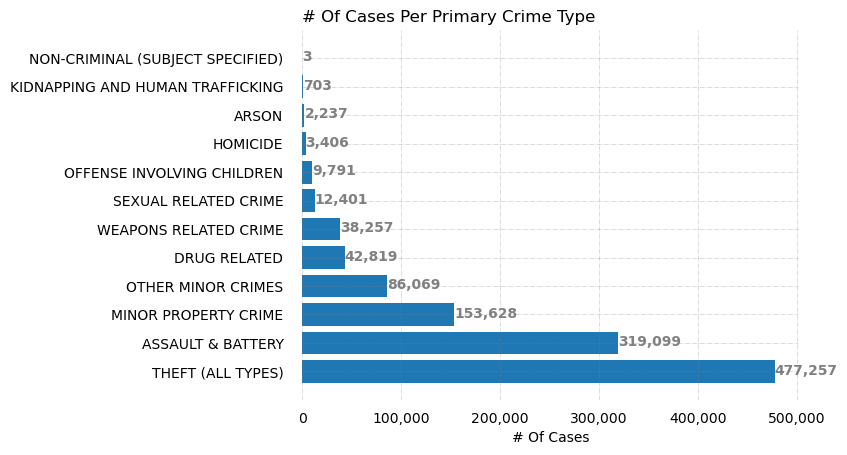

In [4]:
# Generate a bar plot
pandas_df_bar = pd.DataFrame(data_df.groupby(["Primary Type"], as_index=False)["Case Number"].count()).sort_values("Case Number", ascending=True)
pandas_df_bar

count = pandas_df_bar['Case Number']
ptype = pandas_df_bar['Primary Type']

# Figure Size
fig, ax = plt.subplots()
 
# Horizontal Bar Plot
ax.barh(ptype, count)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Add x, y gridlines
ax.grid(color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.4)

# Show top values
ax.invert_yaxis()

plt.xlabel("# Of Cases")

# Add annotation to bars
for i in ax.patches:

    num = i.get_width()
    num_format = '{:,.0f}'.format(num)
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             num_format,
             fontsize = 10, fontweight ='bold',
             color ='grey')
 
# Add Plot Title
ax.set_title('# Of Cases Per Primary Crime Type', loc ='left')

# Show Plot
plt.show()

pandas_df_bar.to_excel("first.xlsx")


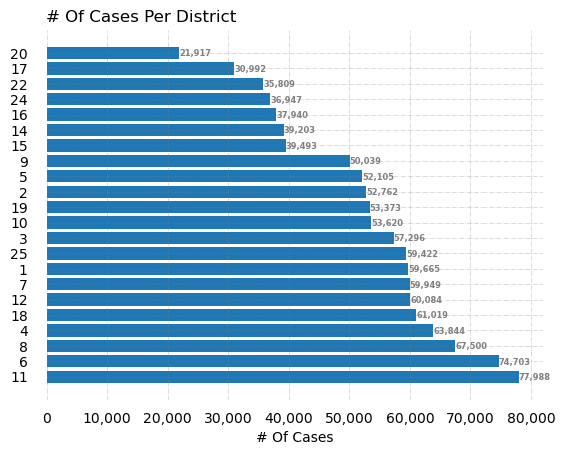

In [5]:
# Generate a bar plot
pandas_df_bar_district = pd.DataFrame(data_df.groupby(["District"], as_index=False)["Case Number"].count()).sort_values("Case Number", ascending=False)

pandas_df_bar_district["District"] = pandas_df_bar_district["District"].astype(str)

count = pandas_df_bar_district['Case Number']
ptype = pandas_df_bar_district['District']

# Figure Size
fig, ax = plt.subplots()
 
# Horizontal Bar Plot
ax.barh(ptype, count)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Add x, y gridlines
ax.grid(color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.4)

# Show top values
# ax.invert_yaxis()

plt.xlabel("# Of Cases")

# Add annotation to bars
for i in ax.patches:

    num = i.get_width()
    num_format = '{:,.0f}'.format(num)
    plt.text(i.get_width()+0.2, i.get_y()+0.2,
             num_format,
             fontsize = 6, fontweight ='bold',
             color ='grey')
 
# Add Plot Title
ax.set_title('# Of Cases Per District', loc ='left')

# Show Plot
plt.show()


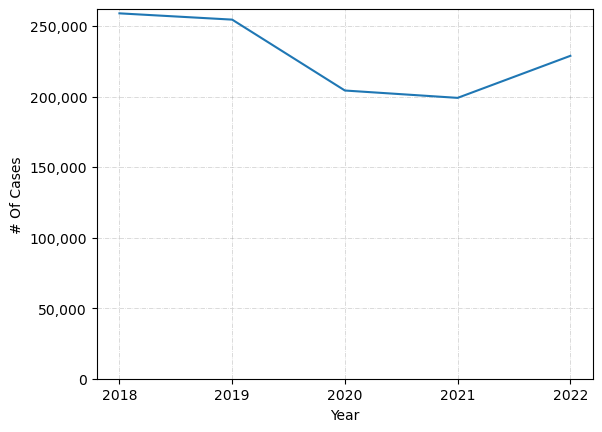

In [6]:
pandas_df_bar_year = pd.DataFrame(data_df.groupby(["Year"], as_index=False)["Case Number"].count())

pandas_df_bar_year.rename(columns = {"Case Number": "Total"}, inplace=True)

pandas_df_bar_year["Year"] = pandas_df_bar_year["Year"].astype(str)

pandas_df_bar_year

years = pandas_df_bar_year["Year"]
vol = pandas_df_bar_year["Total"]

# Figure Size
fig, ax = plt.subplots()
 
ax.plot(years, vol)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.grid(color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.4)

plt.xlabel("Year")
plt.ylim(bottom=0)
plt.ylabel("# Of Cases")
plt.show()


#    1) What is the most and least prevalent type of crime in Chicago?  END

#    2) Are certain areas more prone to crime than others? CHI TEST START


In [ ]:
from pathlib import Path
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime

In [2]:
 # Create a file path 
url = "/Users/aileen/Downloads/chicago_crimes_all_cleaned (2).csv"

 # Read in the data. 
crime_data = pd.read_csv(url)
crime_data.head()

,Case Number,Date,Block,Primary Type,Description,District,Ward,Year,Latitude,Longitude,Location,Population,Zipcode
0,JC104662,12/31/2018 11:59:00 PM,112XX S SACRAMENTO AVE,MINOR PROPERTY CRIME,TO VEHICLE,22,19.0,2018,41.689079,-87.696064,"(41.689078832, -87.696064026)",28804.0,60655.0
1,JC100043,12/31/2018 11:57:00 PM,084XX S SANGAMON ST,MINOR PROPERTY CRIME,TO PROPERTY,6,21.0,2018,41.740521,-87.647391,"(41.740520866, -87.647390719)",68096.0,60620.0
2,JC100006,12/31/2018 11:56:00 PM,018XX S ALLPORT ST,ASSAULT & BATTERY,AGG: HANDS/FIST/FEET NO/MINOR INJURY,12,25.0,2018,41.857068,-87.657625,"(41.857068095, -87.657625201)",79205.0,60608.0
3,JC100031,12/31/2018 11:55:00 PM,078XX S SANGAMON ST,ASSAULT & BATTERY,DOMESTIC BATTERY SIMPLE,6,17.0,2018,41.751914,-87.647717,"(41.75191443, -87.647716532)",68096.0,60620.0
4,JC100026,12/31/2018 11:49:00 PM,052XX W GLADYS AVE,ASSAULT & BATTERY,AGGRAVATED - HANDGUN,15,29.0,2018,41.875684,-87.760479,"(41.87568438, -87.760479356)",47712.0,60644.0


In [3]:
#calculating the total count of districts 
counts_of_districts = crime_data["District"].nunique()
counts_of_districts

22

In [6]:
#calculating total crime
total_crime = crime_data["Primary Type"].count()
total_crime

1145670

In [7]:
crime_count_by_district = crime_data.groupby("District")["Primary Type"].count()
crime_count_by_district

District
1     59665
2     52762
3     57296
4     63844
5     52105
6     74703
7     59949
8     67500
9     50039
10    53620
11    77988
12    60084
14    39203
15    39493
16    37940
17    30992
18    61019
19    53373
20    21917
22    35809
24    36947
25    59422
Name: Primary Type, dtype: int64

In [8]:
#expected value
expected_total = total_crime/22
expected_total

52075.90909090909

In [9]:
# Observed counts of crime by district (cumulative, over the last 5 years)
observed = pd.Series([59665.00000000000,52762.00000000000,57296.00000000000,63844.00000000000,52105.00000000000,74703.00000000000,59949.00000000000,67500.00000000000,50039.00000000000,53620.00000000000,77988.00000000000,60084.00000000000,39203.00000000000,39493.00000000000,37940.00000000000,30992.00000000000,61019.00000000000,53373.00000000000,21917.00000000000,35809.00000000000,36947.00000000000,59422.00000000000], 
                     index=['1','2','3','4','5','6','7','8','9','10','11','12','14','15','16','17','18','19','20','22','24','25'])

In [10]:
# Create a data frame
df = pd.DataFrame([observed]).T

In [11]:
# Add a column whose default values are the expected values
df[1] = 52075.90909090909

In [12]:
# Rename columns
df.columns = ["observed", "expected"]

In [13]:
# View the data frame
df 

,observed,expected
1,59665.0,52075.909091
2,52762.0,52075.909091
3,57296.0,52075.909091
4,63844.0,52075.909091
5,52105.0,52075.909091
6,74703.0,52075.909091
7,59949.0,52075.909091
8,67500.0,52075.909091
9,50039.0,52075.909091
10,53620.0,52075.909091


In [14]:
# The degree of freedom is 22-1 = 21
# With a p-value of 0.05, the confidence level is 1.00-0.05 = 0.95.
critical_value = stats.chi2.ppf(q = 0.95, df = 21)
# The critical value
critical_value 

32.670573340917315

In [15]:
# Run the chi square test with stats.chisquare()
stats.chisquare(df['observed'], df['expected']) 

Power_divergenceResult(statistic=82280.93870311696, pvalue=0.0)

Conclusion

Since the chi square value of 82,281 exceeds the critical value of 32.67, we conclude that the results are statistically significant.

In [16]:
#get an array of all years
years = crime_data["Year"].unique()

In [17]:
# Split data file into years
df_2018 = crime_data[crime_data["Year"]==2018]
df_2019 = crime_data[crime_data["Year"]==2019]
df_2020 = crime_data[crime_data["Year"]==2020]
df_2021 = crime_data[crime_data["Year"]==2021]
df_2022 = crime_data[crime_data["Year"]==2022]
df_2018

,Case Number,Date,Block,Primary Type,Description,District,Ward,Year,Latitude,Longitude,Location,Population,Zipcode
0,JC104662,12/31/2018 11:59:00 PM,112XX S SACRAMENTO AVE,MINOR PROPERTY CRIME,TO VEHICLE,22,19.0,2018,41.689079,-87.696064,"(41.689078832, -87.696064026)",28804.0,60655.0
1,JC100043,12/31/2018 11:57:00 PM,084XX S SANGAMON ST,MINOR PROPERTY CRIME,TO PROPERTY,6,21.0,2018,41.740521,-87.647391,"(41.740520866, -87.647390719)",68096.0,60620.0
2,JC100006,12/31/2018 11:56:00 PM,018XX S ALLPORT ST,ASSAULT & BATTERY,AGG: HANDS/FIST/FEET NO/MINOR INJURY,12,25.0,2018,41.857068,-87.657625,"(41.857068095, -87.657625201)",79205.0,60608.0
3,JC100031,12/31/2018 11:55:00 PM,078XX S SANGAMON ST,ASSAULT & BATTERY,DOMESTIC BATTERY SIMPLE,6,17.0,2018,41.751914,-87.647717,"(41.75191443, -87.647716532)",68096.0,60620.0
4,JC100026,12/31/2018 11:49:00 PM,052XX W GLADYS AVE,ASSAULT & BATTERY,AGGRAVATED - HANDGUN,15,29.0,2018,41.875684,-87.760479,"(41.87568438, -87.760479356)",47712.0,60644.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
894540,JB115033,01/02/2018 11:00:00 AM,064XX W ADDISON ST,THEFT (ALL TYPES),OVER $500,16,36.0,2018,41.945654,-87.786853,"(41.945653748, -87.786852586)",24272.0,60706.0
894541,JB101356,01/02/2018 08:05:00 AM,051XX N NORMANDY AVE,ASSAULT & BATTERY,SIMPLE,16,41.0,2018,41.974559,-87.793957,"(41.974559221, -87.793956917)",24272.0,60706.0
894542,JB101127,01/01/2018 10:30:00 PM,062XX W CORNELIA AVE,OTHER MINOR CRIMES,HARASSMENT BY ELECTRONIC MEANS,16,36.0,2018,41.943873,-87.782380,"(41.943873325, -87.782379691)",24272.0,60706.0
894543,JB100762,01/01/2018 12:00:00 PM,063XX W WAVELAND AVE,OTHER MINOR CRIMES,HARASSMENT BY ELECTRONIC MEANS,16,38.0,2018,41.947501,-87.784668,"(41.947501166, -87.784667989)",24272.0,60706.0


In [18]:
# Create a data frame of population from year to year, noting that zip codes repeat, thus creating repeated population counts,
# since we pulled population based on zip code. So, we groupby unique zip code, get the population for each zip code, and sum by population,
# then by population across all zip codes for one year
population = [df_2018.groupby("Zipcode")["Population"].unique().sum().sum(),
              df_2019.groupby("Zipcode")["Population"].unique().sum().sum(),
              df_2020.groupby("Zipcode")["Population"].unique().sum().sum(),
              df_2021.groupby("Zipcode")["Population"].unique().sum().sum(),
              df_2022.groupby("Zipcode")["Population"].unique().sum().sum()]


In [19]:
# Look at types of crime per capita on the year level
# Count total crimes by crime type per year
year_crime_cnt = crime_data.groupby("Year")["Primary Type"].count()
year_crime_cnt

# Put it in a dataframe
crime_by_year = pd.DataFrame({"Year" : year_crime_cnt.index, "Total Crime" : year_crime_cnt.values})
crime_by_year

,Year,Total Crime
0,2018,258966
1,2019,254518
2,2020,204271
3,2021,199060
4,2022,228855


In [20]:
#total number of unique crime
crime_2018 = df_2018["Primary Type"].count()
crime_2018

258966

In [21]:
#crime by district
crime_by_district_2018 = df_2018.groupby("District")["Primary Type"].count()
crime_by_district_2018

District
1     15249
2     11608
3     11926
4     13569
5     11775
6     16272
7     14124
8     15203
9     10874
10    12480
11    18817
12    12818
14     9151
15     8778
16     7945
17     7201
18    15829
19    11930
20     4836
22     7887
24     7546
25    13148
Name: Primary Type, dtype: int64

In [22]:
#expected value
expected_2018 = crime_2018/22
expected_2018

11771.181818181818

In [23]:
# Observed counts of crime by district
observed_2018 = pd.Series([15249.000000000000,11608.000000000000,11926.000000000000,13569.000000000000,11775.000000000000,16272.000000000000,14124.000000000000,15203.000000000000,10874.000000000000,12480.000000000000,18817.000000000000,12818.000000000000,9151.000000000000,8778.000000000000,7945.000000000000,7201.000000000000,15829.000000000000,11930.000000000000,4836.000000000000,7887.000000000000,7546.000000000000,13148.000000000000], 
                     index=['1','2','3','4','5','6','7','8','9','10','11','12','14','15','16','17','18','19','20','22','24','25'])

In [24]:
# Create a data frame
chi_2018 = pd.DataFrame([observed_2018]).T

In [25]:
 # Add a column whose default values are the expected values
chi_2018[1] = 11771.181818181818

In [26]:
# Rename columns
chi_2018.columns = ["observed", "expected"]

In [27]:
# View the data frame
chi_2018

,observed,expected
1,15249.0,11771.181818
2,11608.0,11771.181818
3,11926.0,11771.181818
4,13569.0,11771.181818
5,11775.0,11771.181818
6,16272.0,11771.181818
7,14124.0,11771.181818
8,15203.0,11771.181818
9,10874.0,11771.181818
10,12480.0,11771.181818


In [28]:
# Run the chi square test with stats.chisquare()
stats.chisquare(chi_2018['observed'], chi_2018['expected'])

Power_divergenceResult(statistic=21728.357884818855, pvalue=0.0)

Conclusion

Since the chi square value of 21,728 exceeds the critical value of 32.67, we conclude that the results are statistically significant.

In [29]:
#total number of unique crime
crime_2019 = df_2019["Primary Type"].count()
crime_2019

254518

In [30]:
#crime by district
crime_by_district_2019 = df_2019.groupby("District")["Primary Type"].count()
crime_by_district_2019

District
1     15002
2     11072
3     12404
4     13518
5     11274
6     16755
7     13674
8     14598
9     10934
10    12413
11    18597
12    12960
14     9106
15     8867
16     7710
17     6440
18    14919
19    11531
20     4284
22     7745
24     7874
25    12841
Name: Primary Type, dtype: int64

In [31]:
#expected value
expected_2019 = crime_2019/22
expected_2019

11569.0

In [32]:
# Observed counts of crime by district
observed_2019 = pd.Series([15002, 11072,12404,13518,11274,16755,13674,14598,10934,12413,18597,12960,9106,8867,7710,6440,14919,11531,4284,7745,7874,12841], 
                     index=['1','2','3','4','5','6','7','8','9','10','11','12','14','15','16','17','18','19','20','22','24','25'])

In [33]:
# Create a data frame
chi_2019 = pd.DataFrame([observed_2019]).T

In [34]:
 # Add a column whose default values are the expected values
chi_2019[1] = 11569

In [35]:
# Rename columns
chi_2019.columns = ["observed", "expected"]

In [37]:
# View the data frame
chi_2019

,observed,expected
1,15002,11569
2,11072,11569
3,12404,11569
4,13518,11569
5,11274,11569
6,16755,11569
7,13674,11569
8,14598,11569
9,10934,11569
10,12413,11569


In [38]:
# Run the chi square test with stats.chisquare()
stats.chisquare(chi_2019['observed'], chi_2019['expected'])

Power_divergenceResult(statistic=22328.108393119543, pvalue=0.0)

Conclusion

Since the chi square value of 22,328 exceeds the critical value of 32.67, we conclude that the results are statistically significant.

In [39]:
#total number of unique crime
crime_2020 = df_2020["Primary Type"].count()
crime_2020

204271

In [40]:
#crime by district
crime_by_district_2020 = df_2020.groupby("District")["Primary Type"].count()
crime_by_district_2020

District
1      8150
2      9270
3     10869
4     11711
5     10067
6     13902
7     11648
8     12178
9      9105
10     9994
11    14780
12     9886
14     6455
15     7813
16     7024
17     5566
18     8555
19     8977
20     3930
22     6628
24     6621
25    11142
Name: Primary Type, dtype: int64

In [41]:
#expected value
expected_2020 = crime_2020/22
expected_2020

9285.045454545454

In [42]:
# Observed counts of crime by district
observed_2020 = pd.Series([8150.000000000000,9270.000000000000,10869.000000000000,11711.000000000000,10067.000000000000,13902.000000000000,11648.000000000000,12178.000000000000,9105.000000000000,9994.000000000000,14780.000000000000,9886.000000000000,6455.000000000000,7813.000000000000,7024.000000000000,5566.000000000000,8555.000000000000,8977.000000000000,3930.000000000000,6628.000000000000,6621.000000000000,11142.000000000000], 
                     index=['1','2','3','4','5','6','7','8','9','10','11','12','14','15','16','17','18','19','20','22','24','25'])

In [43]:
# Create a data frame
chi_2020 = pd.DataFrame([observed_2020]).T

In [44]:
 # Add a column whose default values are the expected values
chi_2020[1] = 9285.045454545454

In [45]:
# Rename columns
chi_2020.columns = ["observed", "expected"]

In [46]:
# View the data frame
chi_2020

,observed,expected
1,8150.0,9285.045455
2,9270.0,9285.045455
3,10869.0,9285.045455
4,11711.0,9285.045455
5,10067.0,9285.045455
6,13902.0,9285.045455
7,11648.0,9285.045455
8,12178.0,9285.045455
9,9105.0,9285.045455
10,9994.0,9285.045455


In [47]:
 # Run the chi square test with stats.chisquare()
stats.chisquare(chi_2020['observed'], chi_2020['expected'])

Power_divergenceResult(statistic=16443.998007548795, pvalue=0.0)

Conclusion

Since the chi square value of 16,443 exceeds the critical value of 32.67, we conclude that the results are statistically significant.

In [48]:
#total number of unique crime
crime_2021 = df_2021["Primary Type"].count()
crime_2021

199060

In [49]:
#crime by district
crime_by_district_2021 = df_2021.groupby("District")["Primary Type"].count()
crime_by_district_2021

District
1      8768
2      9313
3     10350
4     11805
5      9395
6     13307
7     10339
8     11845
9      8949
10     8938
11    12906
12    10506
14     6618
15     6869
16     7097
17     5315
18     9716
19     9216
20     4073
22     6473
24     6660
25    10602
Name: Primary Type, dtype: int64

In [50]:
#expected value
expected_2021 = crime_2021/22
expected_2021

9048.181818181818

In [51]:
# Observed counts of crime by district
observed_2021 = pd.Series([8768.000000000000,9313.000000000000,10350.000000000000,11805.000000000000,9395.000000000000,13307.000000000000,10339.000000000000,11845.000000000000,8949.000000000000,8938.000000000000,12906.000000000000,10506.000000000000,6618.000000000000,6869.000000000000,7097.000000000000,5315.000000000000,9716.000000000000,9216.000000000000,4073.000000000000,6473.000000000000,6660.000000000000,10602.000000000000], 
                     index=['1','2','3','4','5','6','7','8','9','10','11','12','14','15','16','17','18','19','20','22','24','25'])

In [52]:
# Create a data frame
chi_2021 = pd.DataFrame([observed_2021]).T

In [53]:
 # Add a column whose default values are the expected values
chi_2021[1] = 9048.181818181818

In [54]:
# Rename columns
chi_2021.columns = ["observed", "expected"]

In [55]:
# View the data frame
chi_2021

,observed,expected
1,8768.0,9048.181818
2,9313.0,9048.181818
3,10350.0,9048.181818
4,11805.0,9048.181818
5,9395.0,9048.181818
6,13307.0,9048.181818
7,10339.0,9048.181818
8,11845.0,9048.181818
9,8949.0,9048.181818
10,8938.0,9048.181818


In [56]:
 # Run the chi square test with stats.chisquare()
stats.chisquare(chi_2021['observed'], chi_2021['expected'])

Power_divergenceResult(statistic=13549.006611072038, pvalue=0.0)

Conclusion

Since the chi square value of 13,549 exceeds the critical value of 32.67, we conclude that the results are statistically significant.

In [57]:
#total number of unique crime
crime_2022 = df_2022["Primary Type"].count()
crime_2022

228855

In [58]:
#crime by district
crime_by_district_2022 = df_2022.groupby("District")["Primary Type"].count()
crime_by_district_2022

District
1     12496
2     11499
3     11747
4     13241
5      9594
6     14467
7     10164
8     13676
9     10177
10     9795
11    12888
12    13914
14     7873
15     7166
16     8164
17     6470
18    12000
19    11719
20     4794
22     7076
24     8246
25    11689
Name: Primary Type, dtype: int64

In [59]:
#expected value
expected_2022 = crime_2022/22
expected_2022

10402.5

In [60]:
# Observed counts of crime by district
observed_2022 = pd.Series([12496.0,11499.0,11747.0,13241.0,9594.0,14467.0,10164.0,13676.0,10177.0,9795.0,12888.0,13914.0,7873.0,7166.0,8164.0,6470.0,12000.0,11719.0,4794.0,7076.0,8246.0,11689.0], 
                     index=['1','2','3','4','5','6','7','8','9','10','11','12','14','15','16','17','18','19','20','22','24','25'])

In [61]:
# Create a data frame
chi_2022 = pd.DataFrame([observed_2022]).T

In [62]:
 # Add a column whose default values are the expected values
chi_2022[1] = 10402.5

In [63]:
# Rename columns
chi_2022.columns = ["observed", "expected"]

In [64]:
# View the data frame
chi_2022

,observed,expected
1,12496.0,10402.5
2,11499.0,10402.5
3,11747.0,10402.5
4,13241.0,10402.5
5,9594.0,10402.5
6,14467.0,10402.5
7,10164.0,10402.5
8,13676.0,10402.5
9,10177.0,10402.5
10,9795.0,10402.5


In [65]:
 # Run the chi square test with stats.chisquare()
stats.chisquare(chi_2022['observed'], chi_2022['expected'])

Power_divergenceResult(statistic=14687.330112953618, pvalue=0.0)

Conclusion

Since the chi square value of 14,687 exceeds the critical value of 32.67, we conclude that the results are statistically significant.

In [66]:
# Look at per capita crime rate per district over the five year timespan
district_df = crime_data[["Year", "District", "Primary Type", "Population", "Zipcode"]]
district_df

# Get the population per district by creating a new data frame and dropping any unique combinations of distict, zip code, and population
unique_pop = district_df[["District", "Zipcode", "Population"]].drop_duplicates()
pop_per_district = unique_pop.groupby("District")["Population"].sum()

# Get the per capita crime count
cnt_per_district = district_df.groupby("District")["Primary Type"].count()
cnt_per_district

# Get the per capita crime count
per_cap_crime_cnt = cnt_per_district/pop_per_district

# Put in a data frame
district_per_capita = pd.DataFrame({"District" : per_cap_crime_cnt.index, "Per Capita Crime Count" : per_cap_crime_cnt.values})
district_per_capita

,District,Per Capita Crime Count
0,1,0.097490
1,2,0.056675
2,3,0.055896
3,4,0.067163
4,5,0.036991
5,6,0.066932
6,7,0.079481
7,8,0.042925
8,9,0.024156
9,10,0.030581


In [115]:
total_capita = district_per_capita["Per Capita Crime Count"].sum()
total_capita

1.0285460386540908

In [116]:
# Observed counts of crime by district (cumulative, over the last 5 years)
per_capita_observed = pd.Series([0.097490000000000000,0.056675000000000000,0.055896000000000000,0.067163000000000000,0.036991000000000000,0.066932000000000000,0.079481000000000000,0.042925000000000000,0.024156000000000000,0.030581000000000000,0.060918000000000000,0.041275000000000000,0.025076000000000000,0.049419000000000000,0.024038000000000000,0.021608000000000000,0.075589000000000000,0.025457000000000000,0.019074000000000000,0.045885000000000000,0.053523000000000000,0.028393000000000000], 
                     index=['1','2','3','4','5','6','7','8','9','10','11','12','14','15','16','17','18','19','20','22','24','25'])

In [127]:
expected_per_capita = (per_capita_observed.sum()) / 22
expected_per_capita

0.04675204545454545

In [128]:
# Create a data frame
chi_per_capita = pd.DataFrame([per_capita_observed]).T

In [129]:
# Add a column whose default values are the expected values
chi_per_capita[1] = expected_per_capita

In [130]:
# Rename columns
chi_per_capita.columns = ["observed", "expected"]

In [131]:
# View the data frame
chi_per_capita 

,observed,expected
1,0.097490,0.046752
2,0.056675,0.046752
3,0.055896,0.046752
4,0.067163,0.046752
5,0.036991,0.046752
6,0.066932,0.046752
7,0.079481,0.046752
8,0.042925,0.046752
9,0.024156,0.046752
10,0.030581,0.046752


In [132]:
# Run the chi square test with stats.chisquare()
stats.chisquare(chi_per_capita['observed'], chi_per_capita['expected']) 

Power_divergenceResult(statistic=0.21013004358292542, pvalue=1.0)

#    2) Are certain areas more prone to crime than others? CHI TEST END


#   2) Are certain areas more prone to crime than others? FURTHER ANALYSIS START


In [132]:
%%capture --no-display

# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import pprint
from uszipcode import SearchEngine
from config import api_key
from census import Census
import hvplot.pandas
import dataframe_image as dfi

## Data Organization

In [133]:
# Read in data from csv file
final_df = pd.read_csv("chicago_crimes_all_cleaned.csv")
final_df

,Case Number,Date,Block,Primary Type,Description,District,Ward,Year,Latitude,Longitude,Location,Population,Zipcode
0,JC104662,12/31/2018 11:59:00 PM,112XX S SACRAMENTO AVE,MINOR PROPERTY CRIME,TO VEHICLE,22,19.0,2018,41.689079,-87.696064,"(41.689078832, -87.696064026)",28804.0,60655.0
1,JC100043,12/31/2018 11:57:00 PM,084XX S SANGAMON ST,MINOR PROPERTY CRIME,TO PROPERTY,6,21.0,2018,41.740521,-87.647391,"(41.740520866, -87.647390719)",68096.0,60620.0
2,JC100006,12/31/2018 11:56:00 PM,018XX S ALLPORT ST,ASSAULT & BATTERY,AGG: HANDS/FIST/FEET NO/MINOR INJURY,12,25.0,2018,41.857068,-87.657625,"(41.857068095, -87.657625201)",79205.0,60608.0
3,JC100031,12/31/2018 11:55:00 PM,078XX S SANGAMON ST,ASSAULT & BATTERY,DOMESTIC BATTERY SIMPLE,6,17.0,2018,41.751914,-87.647717,"(41.75191443, -87.647716532)",68096.0,60620.0
4,JC100026,12/31/2018 11:49:00 PM,052XX W GLADYS AVE,ASSAULT & BATTERY,AGGRAVATED - HANDGUN,15,29.0,2018,41.875684,-87.760479,"(41.87568438, -87.760479356)",47712.0,60644.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145665,JF420379,9/16/2022 13:48,026XX N NARRAGANSETT AVE,THEFT (ALL TYPES),RETAIL THEFT,25,36.0,2022,41.928077,-87.785606,"(41.928076536, -87.785606186)",41309.0,60707.0
1145666,JF420478,9/1/2022 5:00,005XX W SURF ST,OTHER MINOR CRIMES,HARASSMENT BY TELEPHONE,19,44.0,2022,41.934305,-87.641485,"(41.934304581, -87.641484982)",72113.0,60657.0
1145667,JF420319,7/8/2022 0:00,114XX S PRAIRIE AVE,THEFT (ALL TYPES),FRAUD OR CONFIDENCE GAME,5,9.0,2022,41.685544,-87.616813,"(41.685543881, -87.616812541)",64489.0,60628.0
1145668,JF420102,9/27/2022 11:00,023XX E 70TH ST,THEFT (ALL TYPES),OVER $500,3,5.0,2022,41.768068,-87.567453,"(41.768068052, -87.567452932)",48973.0,60649.0


In [134]:
# Get an array of all years
years = final_df["Year"].unique()

In [135]:
# Split data file into years
df_2018 = final_df[final_df["Year"]==2018]
df_2019 = final_df[final_df["Year"]==2019]
df_2020 = final_df[final_df["Year"]==2020]
df_2021 = final_df[final_df["Year"]==2021]
df_2022 = final_df[final_df["Year"]==2022]
df_2018

,Case Number,Date,Block,Primary Type,Description,District,Ward,Year,Latitude,Longitude,Location,Population,Zipcode
0,JC104662,12/31/2018 11:59:00 PM,112XX S SACRAMENTO AVE,MINOR PROPERTY CRIME,TO VEHICLE,22,19.0,2018,41.689079,-87.696064,"(41.689078832, -87.696064026)",28804.0,60655.0
1,JC100043,12/31/2018 11:57:00 PM,084XX S SANGAMON ST,MINOR PROPERTY CRIME,TO PROPERTY,6,21.0,2018,41.740521,-87.647391,"(41.740520866, -87.647390719)",68096.0,60620.0
2,JC100006,12/31/2018 11:56:00 PM,018XX S ALLPORT ST,ASSAULT & BATTERY,AGG: HANDS/FIST/FEET NO/MINOR INJURY,12,25.0,2018,41.857068,-87.657625,"(41.857068095, -87.657625201)",79205.0,60608.0
3,JC100031,12/31/2018 11:55:00 PM,078XX S SANGAMON ST,ASSAULT & BATTERY,DOMESTIC BATTERY SIMPLE,6,17.0,2018,41.751914,-87.647717,"(41.75191443, -87.647716532)",68096.0,60620.0
4,JC100026,12/31/2018 11:49:00 PM,052XX W GLADYS AVE,ASSAULT & BATTERY,AGGRAVATED - HANDGUN,15,29.0,2018,41.875684,-87.760479,"(41.87568438, -87.760479356)",47712.0,60644.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
894540,JB115033,01/02/2018 11:00:00 AM,064XX W ADDISON ST,THEFT (ALL TYPES),OVER $500,16,36.0,2018,41.945654,-87.786853,"(41.945653748, -87.786852586)",24272.0,60706.0
894541,JB101356,01/02/2018 08:05:00 AM,051XX N NORMANDY AVE,ASSAULT & BATTERY,SIMPLE,16,41.0,2018,41.974559,-87.793957,"(41.974559221, -87.793956917)",24272.0,60706.0
894542,JB101127,01/01/2018 10:30:00 PM,062XX W CORNELIA AVE,OTHER MINOR CRIMES,HARASSMENT BY ELECTRONIC MEANS,16,36.0,2018,41.943873,-87.782380,"(41.943873325, -87.782379691)",24272.0,60706.0
894543,JB100762,01/01/2018 12:00:00 PM,063XX W WAVELAND AVE,OTHER MINOR CRIMES,HARASSMENT BY ELECTRONIC MEANS,16,38.0,2018,41.947501,-87.784668,"(41.947501166, -87.784667989)",24272.0,60706.0


## Perform Per Capita Calculations, Tables, and Graphs

In [136]:
# Create a data frame of population from year to year, noting that zip codes repeat, thus creating repeated population counts,
# since we pulled population based on zip code. So, we groupby unique zip code, get the population for each zip code, and sum by population,
# then by population across all zip codes for one year
population = [df_2018.groupby("Zipcode")["Population"].unique().sum().sum(),
              df_2019.groupby("Zipcode")["Population"].unique().sum().sum(),
              df_2020.groupby("Zipcode")["Population"].unique().sum().sum(),
              df_2021.groupby("Zipcode")["Population"].unique().sum().sum(),
              df_2022.groupby("Zipcode")["Population"].unique().sum().sum()]

In [137]:
# Look at types of crime per capita on the year level
# Count total crimes by crime type per year
year_crime_cnt = final_df.groupby("Year")["Primary Type"].count()
year_crime_cnt

# Get the population for each year
pop_per_year = population
pop_per_year

# Calculate per capita count
per_capita_crime_rate = year_crime_cnt/pop_per_year

# Put it in a dataframe
yearly_per_capita = pd.DataFrame({"Year" : per_capita_crime_rate.index, "Per Capita Rate" : per_capita_crime_rate.values})
yearly_per_capita

,Year,Per Capita Rate
0,2018,0.086561
1,2019,0.084422
2,2020,0.068019
3,2021,0.066141
4,2022,0.076041


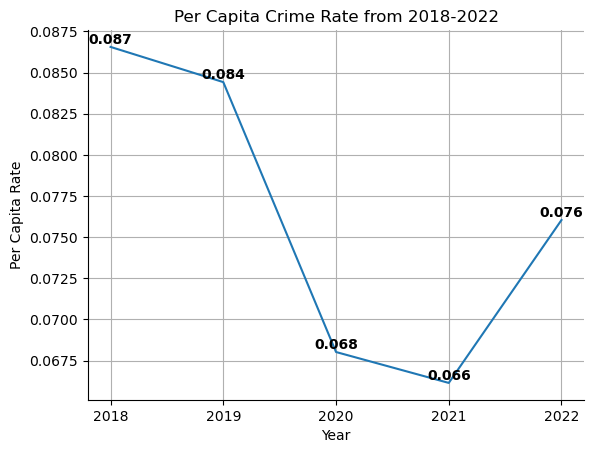

In [138]:
# Graph per capita crime rates over 2018-2022
plt.plot(yearly_per_capita["Year"], yearly_per_capita["Per Capita Rate"])

# Add labels
plt.xlabel("Year")
plt.ylabel("Per Capita Rate")
plt.title("Per Capita Crime Rate from 2018-2022")

# Add values to the line chart
for x, y in zip(yearly_per_capita["Year"], yearly_per_capita["Per Capita Rate"]):
    plt.text(x, y, f"{y:.3f}", ha="center", va="bottom", weight = "bold")

# Create new x-ticks
new_xticks = years
plt.xticks(new_xticks)

# Remove the top and right borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a grid
plt.grid(True)

## Save the figure
plt.savefig("Images/PerCapitaCrimeRate2018_2022.png")
plt.show()

In [139]:
# Look at per capita crime rate per district over the five year timespan
# Grab selected columns we want to look at
district_df = final_df[["Year", "District", "Primary Type", "Population", "Zipcode"]]
district_df

# Get the population per district by creating a new data frame and dropping any unique combinations of distict, zip code, and population,
# since population will be duplicated multiple times when zip code is listed more than once
unique_pop = district_df[["District", "Zipcode", "Population"]].drop_duplicates()
pop_per_district = unique_pop.groupby("District")["Population"].sum()

# Get the count per district by grouping by district and counting primary type of crime
cnt_per_district = district_df.groupby("District")["Primary Type"].count()
cnt_per_district

# Get the per capita crime rate by dividing the count per district by the population per district
per_cap_crime_count = cnt_per_district/pop_per_district

# Put in a data frame for ease of use
district_per_capita = pd.DataFrame({"District" : per_cap_crime_count.index, "Per Capita Crime Rate" : per_cap_crime_count.values})

# Sort the values
district_per_capita.sort_values(by = "Per Capita Crime Rate", ascending = False, inplace=True)
district_per_capita

,District,Per Capita Crime Rate
0,1,0.097490
6,7,0.079481
16,18,0.075589
3,4,0.067163
5,6,0.066932
10,11,0.060918
1,2,0.056675
2,3,0.055896
20,24,0.053523
13,15,0.049419


<Figure size 2000x2000 with 0 Axes>

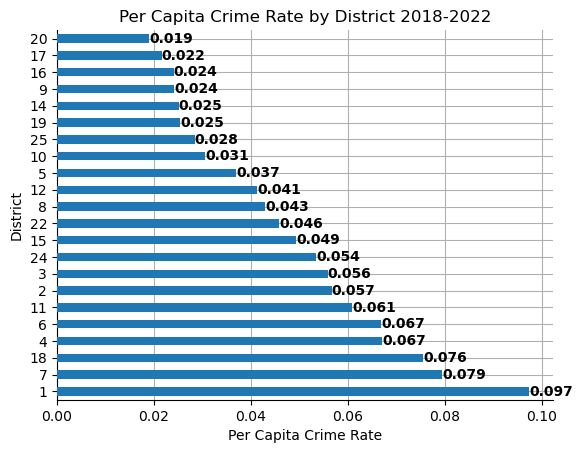

In [140]:
# Graph the per capita crime rate by district
plt.figure(figsize=(20, 20))
ax = district_per_capita.plot.barh(x = "District", y = "Per Capita Crime Rate", legend = False, zorder = 3)

# Set the x and y labels and title
plt.xlabel("Per Capita Crime Rate")
plt.ylabel("District")
plt.title("Per Capita Crime Rate by District 2018-2022")

# Add per capita crime rate values to each bar
for i, v in enumerate(district_per_capita["Per Capita Crime Rate"]):
    ax.text(v, i, f"{v:.3f}", color = "black", ha = "left", va = "center", weight = "bold")

# Remove the top and right borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a grid
plt.grid(True)

# Save the figure
plt.savefig("Images/PerCapitaCrimeRatebyDistrict.png")

# Display the plot
plt.show()

In [141]:
# Look at per capita crime rate by primary type of crime over the five year timespan

# Remove "NON-CRIMINAL (SUBJECT SPECIFIED)" primary type as it contains an extremely small number of data points that we don't want to use
# in visualizations
final_df = final_df[final_df['Primary Type'] != 'NON-CRIMINAL (SUBJECT SPECIFIED)']

# Get the population per primary type by removing duplicates
unique_type_pop = final_df[["Primary Type", "Zipcode", "Population"]].drop_duplicates()

# Get the total population by primary type by grouping by primary type then summing the population
pop_per_type = unique_type_pop.groupby("Primary Type")["Population"].sum()

# Get the crime count for each primary type by grouping and counting by primary type
cnt_per_type = district_df.groupby("Primary Type")["Primary Type"].count()

# Get the per capita crime count by dividing the count of crime type by population per crime type
per_cap_crime_type = cnt_per_type/pop_per_type

# Put in a data frame for easy use
type_per_capita = pd.DataFrame({"Primary Type" : per_cap_crime_type.index, "Per Capita Crime Rate" : per_cap_crime_type.values})

# Sort values in the data frame for easy graphing and reference
type_per_capita.sort_values(by = "Per Capita Crime Rate", ascending = False, inplace = True)
type_per_capita

,Primary Type,Per Capita Crime Rate
10,THEFT (ALL TYPES),0.043681
1,ASSAULT & BATTERY,0.029118
5,MINOR PROPERTY CRIME,0.014018
8,OTHER MINOR CRIMES,0.007878
2,DRUG RELATED,0.003952
11,WEAPONS RELATED CRIME,0.003520
9,SEXUAL RELATED CRIME,0.001138
7,OFFENSE INVOLVING CHILDREN,0.000907
3,HOMICIDE,0.000338
0,ARSON,0.000218


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


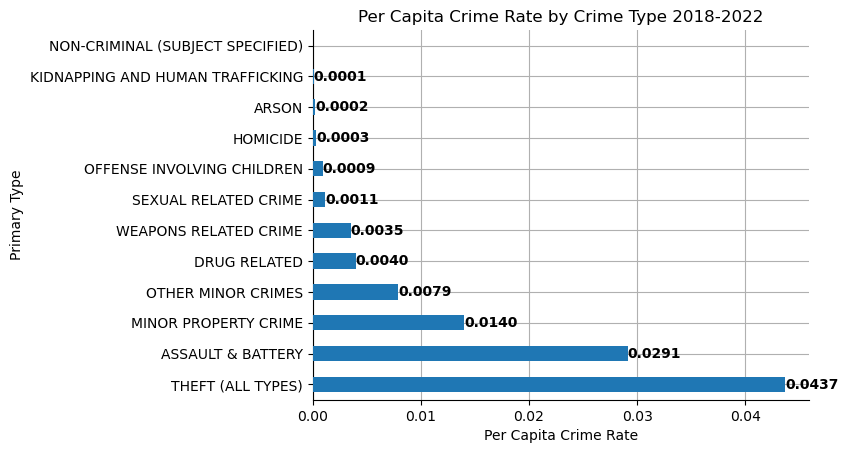

In [142]:
# Graph the results of the type of crime per capita
ax = type_per_capita.plot.barh(x = "Primary Type", y = "Per Capita Crime Rate", legend = False, zorder = 3)

# Set labels and title
plt.xlabel("Per Capita Crime Rate")
plt.ylabel("Primary Type")
plt.title("Per Capita Crime Rate by Crime Type 2018-2022")

# Add per capita crime rate values to each bar
for i, v in enumerate(type_per_capita["Per Capita Crime Rate"]):
    ax.text(v, i, f"{v:.4f}", color = "black", ha = "left", va = "center", weight = "bold")

# Remove the top and right borders
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Add a grid
plt.grid(True)

# Save figure
plt.savefig("Images/PerCapitaCrimeRatebyCrimeType.png")

# Display the plot
plt.show()

## Analyze Data Per Capita Per 1,000 People

In [143]:
# Look at types of crime per capita per 1,000 people  on the year level
# Count total crimes by crime type per year
year_crime_cnt = final_df.groupby("Year")["Primary Type"].count()

# Get the population for each year
pop_per_year = population

# Calculate per capita rate per 1,000 residents in Chicago
per_capita_crime_rate_1000 = year_crime_cnt/pop_per_year*1000

# Put it in a dataframe
yearly_per_capita_1000 = pd.DataFrame({"Year" : per_capita_crime_rate_1000.index, 
                                       "Number of Crimes per Year" : year_crime_cnt, 
                                       "Per Capita Crime Rate (per 1,000 People)" : per_capita_crime_rate_1000.values})
yearly_per_capita_1000 = yearly_per_capita_1000.reset_index(drop = True)
yearly_per_capita_1000

,Year,Number of Crimes per Year,"Per Capita Crime Rate (per 1,000 People)"
0,2018,258963,86.560426
1,2019,254518,84.422063
2,2020,204271,68.019027
3,2021,199060,66.140823
4,2022,228855,76.040681


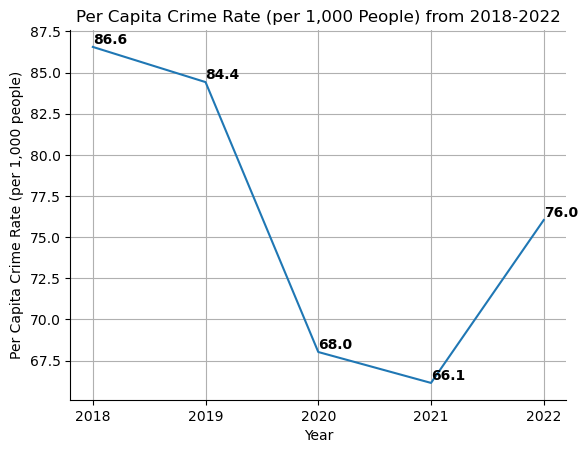

In [144]:
# Graph per capita crime rates over the 5 years per 1,000 residents in Chicago
plt.plot(yearly_per_capita_1000["Year"], yearly_per_capita_1000["Per Capita Crime Rate (per 1,000 People)"])

# Add labels
plt.xlabel("Year")
plt.ylabel("Per Capita Crime Rate (per 1,000 people)")
plt.title("Per Capita Crime Rate (per 1,000 People) from 2018-2022")

# Add values to the line chart
for x, y in zip(yearly_per_capita_1000["Year"], yearly_per_capita_1000["Per Capita Crime Rate (per 1,000 People)"]):
    plt.text(x, y, f"{y:.1f}", ha="left", va="bottom", weight = "bold")

# Create new x-ticks
new_xticks = years
plt.xticks(new_xticks)

# Remove the top and right borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a grid
plt.grid(True)

## Save the figure
plt.savefig("Images/PerCapitaCrimeRate2018_2022(per1000people).png")
plt.show()


In [145]:
# Look at per capita crime rate per district over the five year timespan
# Grab selected columns we want to look at
district_df = final_df[["Year", "District", "Primary Type", "Population", "Zipcode"]]
district_df

# Get the population per district by creating a new data frame and dropping any unique combinations of distict, zip code, and population,
# since population will be duplicated multiple times when zip code is listed more than once
unique_pop_1000 = district_df[["District", "Zipcode", "Population"]].drop_duplicates()
pop_per_district_1000 = unique_pop_1000.groupby("District")["Population"].sum()

# Get the count per district by grouping by district and counting primary type of crime
cnt_per_district_1000 = district_df.groupby("District")["Primary Type"].count()
cnt_per_district_1000
# Get the per capita crime rate by dividing the count per district by the population per district
per_cap_crime_count_1000 = cnt_per_district_1000/pop_per_district_1000 * 1000

# Put in a data frame for ease of use
district_per_capita_1000 = pd.DataFrame({"District" : per_cap_crime_count_1000.index, "Per Capita Crime Rate (per 1,000 People)" : per_cap_crime_count_1000.values})

# Sort the values
district_per_capita_1000.sort_values(by = "Per Capita Crime Rate (per 1,000 People)", ascending = False, inplace=True)
district_per_capita_1000

,District,"Per Capita Crime Rate (per 1,000 People)"
0,1,97.490396
6,7,79.481077
16,18,75.588821
3,4,67.163206
5,6,66.931935
10,11,60.916045
1,2,56.674648
2,3,55.895755
20,24,53.523261
13,15,49.418634


<Figure size 2000x2000 with 0 Axes>

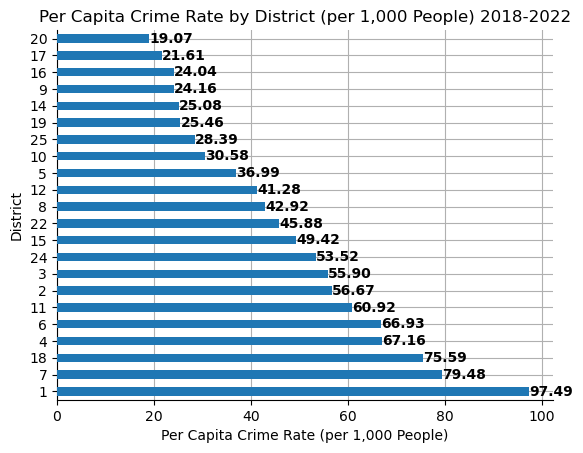

In [146]:
# Graph the per capita crime rate by district per 1,000 people
per_cap_by_dist = plt.figure(figsize=(20, 20))
ax = district_per_capita_1000.plot.barh(x = "District", y = "Per Capita Crime Rate (per 1,000 People)", legend = False, zorder = 3)

# Set axis below bars
ax.set_axisbelow(True)

# Set the x and y labels and title
plt.xlabel("Per Capita Crime Rate (per 1,000 People)")
plt.ylabel("District")
plt.title("Per Capita Crime Rate by District (per 1,000 People) 2018-2022")

# Add per capita crime rate values to each bar
for i, v in enumerate(district_per_capita_1000["Per Capita Crime Rate (per 1,000 People)"]):
    ax.text(v, i, f"{v:.2f}", color = "black", ha = "left", va = "center", weight = "bold")

# Remove the top and right borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a grid
plt.grid(True)

# Save the figure
plt.savefig("Images/PerCapitaCrimeRatebyDistrictper1000People.png")

# Display the plot
plt.show()

In [147]:
# Look at per capita crime rate per district over the five year timespan per 1,000 residents
# Grab the columns we need from district_df
district_df = final_df[["Year", "District", "Primary Type", "Population", "Zipcode"]]
district_df

# Get the population per district by creating a new data frame and dropping any unique combinations of distict, zip code, and population,
# since zip code was used to pull population
unique_pop = district_df[["District", "Zipcode", "Population"]].drop_duplicates()
pop_per_district = unique_pop.groupby("District")["Population"].sum()

# Get the per capita crime count by grouping by District and counting primary type of crime
cnt_per_district = district_df.groupby("District")["Primary Type"].count()
cnt_per_district

# Get the per capita crime count per 1,000 residents
per_cap_crime_cnt_1000 = cnt_per_district/pop_per_district*1000

# Put in a data frame for ease of use
district_per_capita_1000 = pd.DataFrame({"District" : per_cap_crime_cnt_1000.index, 
                                         "Population per District" : pop_per_district, 
                                         "Total Number of Crimes" : cnt_per_district, 
                                         "Per Capita Crime Rate (per 1,000 People) per District" : per_cap_crime_cnt_1000.values})
district_per_capita_1000.sort_values(by = "Per Capita Crime Rate (per 1,000 People) per District", ascending = False, inplace=True)
district_per_capita_1000 = district_per_capita_1000.reset_index(drop = True)
district_per_capita_1000

,District,Population per District,Total Number of Crimes,"Per Capita Crime Rate (per 1,000 People) per District"
0,1,612009.0,59665,97.490396
1,7,754255.0,59949,79.481077
2,18,807249.0,61019,75.588821
3,4,950580.0,63844,67.163206
4,6,1116104.0,74703,66.931935
5,11,1280221.0,77986,60.916045
6,2,930963.0,52762,56.674648
7,3,1025051.0,57296,55.895755
8,24,690298.0,36947,53.523261
9,15,799152.0,39493,49.418634


In [148]:
# Look at per capita crime rate by primary type of crime over the five year timespan per 1,000 people

# Remove "NON-CRIMINAL (SUBJECT SPECIFIED)" primary type as it contains an extremely small number of data points that we don't want to use
# in visualizations
final_df = final_df[final_df['Primary Type'] != 'NON-CRIMINAL (SUBJECT SPECIFIED)']

# Get the population per primary type by removing duplicates
unique_type_pop_1000 = final_df[["Primary Type", "Zipcode", "Population"]].drop_duplicates()

# Get the total population by primary type by grouping by primary type then summing the population
pop_per_type_1000 = unique_type_pop_1000.groupby("Primary Type")["Population"].sum()

# Get the crime count for each primary type by grouping and counting by primary type
cnt_per_type_1000 = district_df.groupby("Primary Type")["Primary Type"].count()

# Get the per capita crime count by dividing the count of crime type by population per crime type
per_cap_crime_type_1000 = cnt_per_type_1000/pop_per_type_1000*1000

# Put in a data frame for easy use
type_per_capita_1000 = pd.DataFrame({"Primary Type" : per_cap_crime_type_1000.index, "Per Capita Crime Rate (per 1,000 People)" : per_cap_crime_type_1000.values})

# Sort values in the data frame for easy graphing and reference
type_per_capita_1000.sort_values(by = "Per Capita Crime Rate (per 1,000 People)", ascending = False, inplace = True)
type_per_capita_1000

,Primary Type,"Per Capita Crime Rate (per 1,000 People)"
9,THEFT (ALL TYPES),43.681153
1,ASSAULT & BATTERY,29.117601
5,MINOR PROPERTY CRIME,14.018467
7,OTHER MINOR CRIMES,7.877502
2,DRUG RELATED,3.952058
10,WEAPONS RELATED CRIME,3.519974
8,SEXUAL RELATED CRIME,1.138044
6,OFFENSE INVOLVING CHILDREN,0.907341
3,HOMICIDE,0.337906
0,ARSON,0.217733


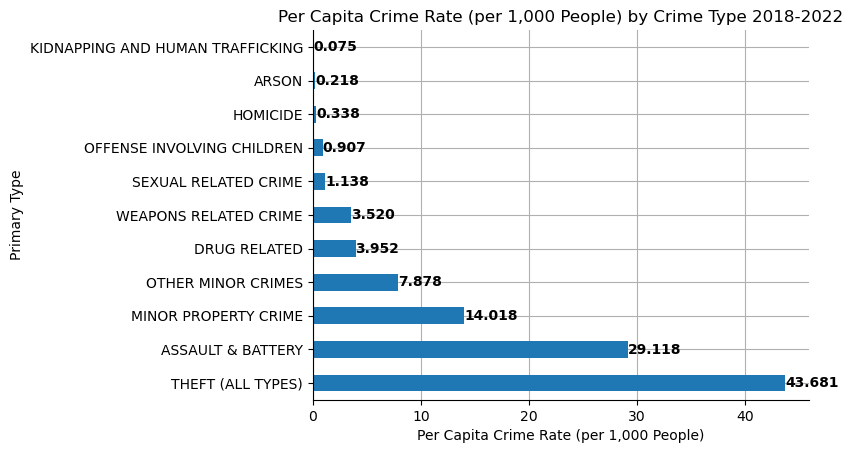

In [149]:
# Graph the results of the type of crime per capita
ax = type_per_capita_1000.plot.barh(x = "Primary Type", y = "Per Capita Crime Rate (per 1,000 People)", legend = False)

# Set axis below bars
ax.set_axisbelow(True)

# Set labels and title
plt.xlabel("Per Capita Crime Rate (per 1,000 People)")
plt.ylabel("Primary Type")
plt.title("Per Capita Crime Rate (per 1,000 People) by Crime Type 2018-2022")

# Add per capita crime rate values to each bar
for i, v in enumerate(type_per_capita_1000["Per Capita Crime Rate (per 1,000 People)"]):
    ax.text(v, i, f"{v:.3f}", color = "black", ha = "left", va = "center", weight = "bold")

# Remove the top and right borders
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Add a grid
plt.grid(True)

# Save figure
plt.savefig("Images/PerCapitaCrimeRatebyCrimeType1000.png")

# Display the plot
plt.show()

## Create Pie Chart Visualizations

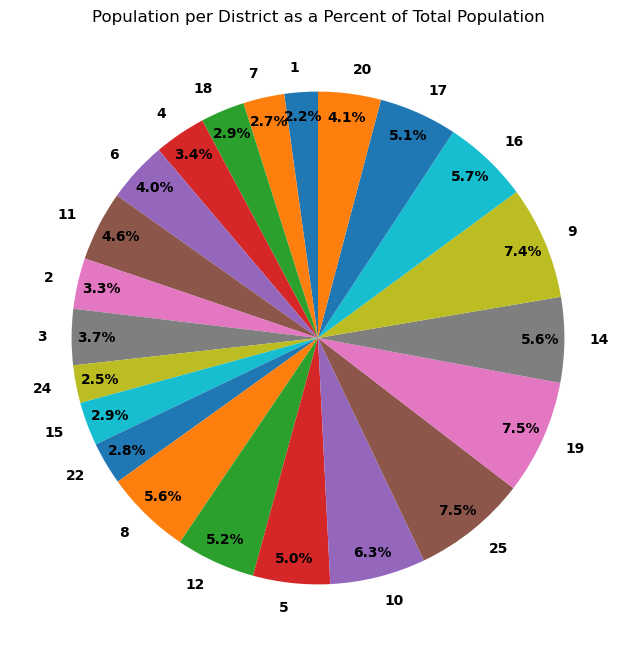

In [ ]:
# Make a pie chart of population per district compared to total population
# Calculate the total population
total_population = district_per_capita_1000["Population per District"].sum()

# Calculate the percentage of population per district
district_per_capita_1000["Population Percentage"] = (district_per_capita_1000["Population per District"] / total_population * 100)

# Create the pie plot
plt.figure(figsize=(8, 8))
patches, labels, percentages = plt.pie(
    district_per_capita_1000["Population Percentage"],
    labels=district_per_capita_1000["District"],
    autopct="%1.1f%%",
    startangle=90,
    # Adjust the distance of the percentages from the center
    pctdistance=0.90,  
    # Adjust text properties
    textprops={"fontsize": 10, "color": "black", "weight": "bold"}  
)

# Add a title
plt.title("Population per District as a Percent of Total Population")

# Save the figure
plt.savefig("Images/PopulationasaPercentofTotalPop.png")

# Display the plot
plt.show()

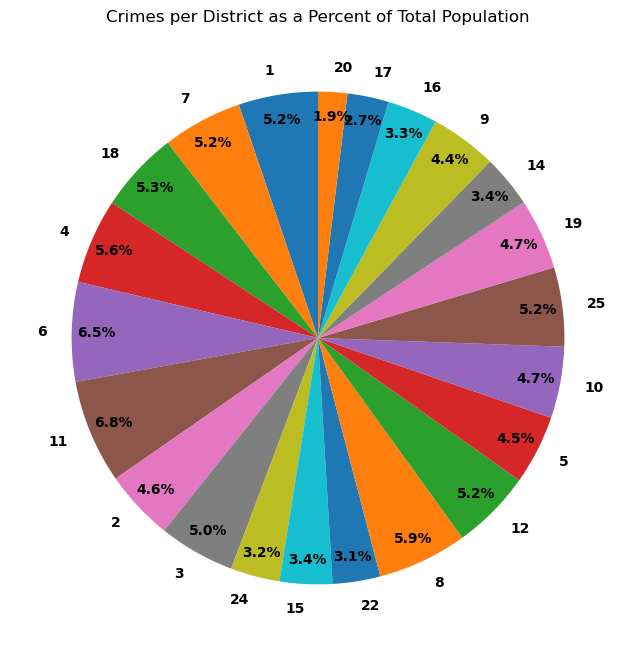

In [ ]:
# Make a pie chart of population per district compared to total number of crimes
# Calculate the total population
total_population = district_per_capita_1000["Total Number of Crimes"].sum()

# Calculate the percentage of population per district
district_per_capita_1000["Total Number of Crimes"] = (district_per_capita_1000["Total Number of Crimes"] / total_population * 100)

# Create the pie plot
plt.figure(figsize=(8, 8))
patches, labels, percentages = plt.pie(
    district_per_capita_1000["Total Number of Crimes"],
    labels=district_per_capita_1000["District"],
    autopct="%1.1f%%",
    startangle=90,
    # Adjust the distance of the percentages from the center
    pctdistance=0.90,  
    # Adjust text properties
    textprops={"fontsize": 10, "color": "black", "weight": "bold"}  
)

# Add a title
plt.title("Crimes per District as a Percent of Total Population")

# Save the figure
plt.savefig("Images/CrimeasaPercentofTotalPop.png")

# Display the plot
plt.show()

## Look at Statistics of Per Capita Crime Rate per 1,000 People

In [ ]:
# Get the per_capita_crime_rates per 1,000 people
per_capita_crime_rates = district_per_capita_1000["Per Capita Crime Rate (per 1,000 People) per District"]

# Calculate summary statistics to see how the districts vary from the mean and median
summary_stats = per_capita_crime_rates.describe()
print(summary_stats)

count    22.000000
mean     46.751993
std      21.628849
min      19.074051
25%      26.190995
50%      44.404731
75%      59.855696
max      97.490396
Name: Per Capita Crime Rate (per 1,000 People) per District, dtype: float64


In [ ]:
# Find the percent difference between the highest and lowest per capita rate (per 1,000 people) for all districts
highest_rate = district_per_capita_1000["Per Capita Crime Rate (per 1,000 People) per District"].max()
lowest_rate = district_per_capita_1000["Per Capita Crime Rate (per 1,000 People) per District"].min()
difference = (highest_rate - lowest_rate)
percent_difference = (highest_rate - lowest_rate) / ((highest_rate + lowest_rate) / 2) * 100
percent_difference

134.54590549165727

## Create other visualizations including maps and summary statistics

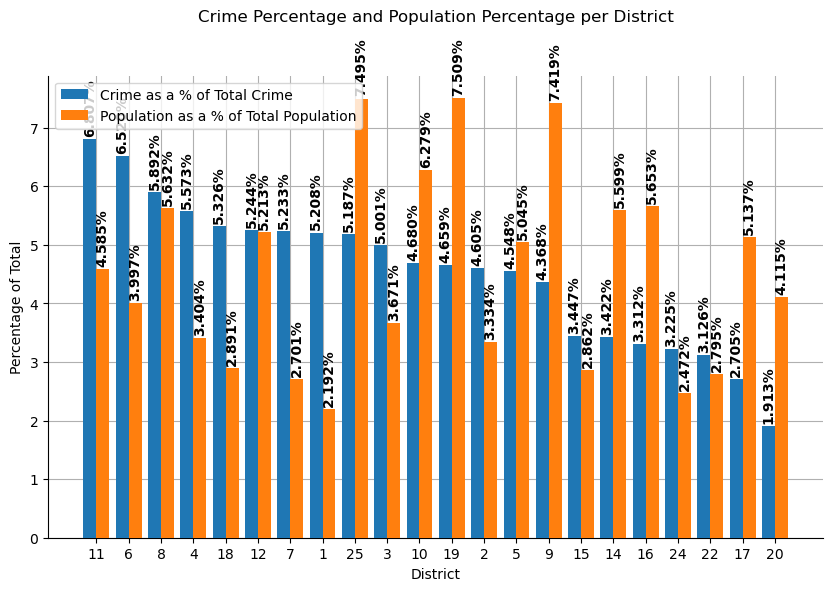

In [ ]:
# Plot a bar chart showing the percentage of crime and population per total
# Calculate the percentage of crime per total crime count for all districts
crime_percentage = cnt_per_district / cnt_per_district.sum() * 100

# Calculate the percentage of population per total population for all districts
population_percentage = pop_per_district / pop_per_district.sum() * 100

# Sort the data in descending order
crime_percentage_sorted = crime_percentage.sort_values(ascending=False)
population_percentage_sorted = population_percentage.loc[crime_percentage_sorted.index]

# Set the bar width
bar_width = 0.4

# Set the x positions of the bars
x = np.arange(len(crime_percentage_sorted))

# Plot the bars for crime percentage
plt.figure(figsize=(10, 6))
plt.bar(x, crime_percentage_sorted, width = bar_width, label = "Crime Percentage", zorder = 3)

# Plot the bars for population percentage
plt.bar(x + bar_width, population_percentage_sorted, width = bar_width, label = "Population Percentage", zorder = 3)

# Set the labels and title
plt.xlabel("District")
plt.ylabel("Percentage of Total")
plt.title("Crime Percentage and Population Percentage per District", y = 1.1)

# Add grid
plt.grid(True)

# Add labels on top of the bars with rotated percentages
for i, v in enumerate(crime_percentage_sorted):
    plt.text(i, v + 0.1, f'{v:.3f}%', ha=  "center", rotation=90, weight = "bold")

for i, v in enumerate(population_percentage_sorted):
    plt.text(i + bar_width, v + 0.1, f'{v:.3f}%', ha = "center", rotation=90, weight = "bold")

# Set the x-axis tick positions and labels
plt.xticks(x + bar_width / 2, crime_percentage_sorted.index)

# Add a legend
plt.legend(["Crime as a % of Total Crime", "Population as a % of Total Population"], loc = "upper left")

# Remove the top and right borders
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

## Save the figure
plt.savefig("Images/PopulationandCrimeasaPercentofTotal.png")

# Display the plot
plt.show()

In [ ]:
# Create a DataFrame with summary statistics using the above created values
crime_pop_summary = pd.DataFrame({
    "District": crime_percentage_sorted.index,
    "Crime %": crime_percentage_sorted.values,
    "Population %": population_percentage_sorted.values,
    "Per Capita Crime Rate (per 1,000 People) per District" : district_per_capita_1000["Per Capita Crime Rate (per 1,000 People) per District"],
    "Mean" : summary_stats["mean"],
    "Difference Between per Capita Rate and Mean" : district_per_capita_1000["Per Capita Crime Rate (per 1,000 People) per District"] - summary_stats["mean"]
})

# Reset the index and sort the table
crime_pop_summary = crime_pop_summary.reset_index(drop = True)
crime_pop_summary = crime_pop_summary.sort_values(by = "Crime %", ascending = False)

# Save DataFrame as .png
crime_pop_summary.dfi.export("SummaryTable.png")
crime_pop_summary

,District,Crime %,Population %,"Per Capita Crime Rate (per 1,000 People) per District",Mean,Difference Between per Capita Rate and Mean
0,11,6.807039,4.584934,97.490396,46.751993,50.738404
1,6,6.520481,3.997172,79.481077,46.751993,32.729085
2,8,5.891677,5.631680,75.588821,46.751993,28.836828
3,4,5.572649,3.404371,67.163206,46.751993,20.411213
4,18,5.326068,2.891050,66.931935,46.751993,20.179942
5,12,5.244456,5.213338,60.916045,46.751993,14.164052
6,7,5.232672,2.701260,56.674648,46.751993,9.922655
7,1,5.207883,2.191825,55.895755,46.751993,9.143763
8,25,5.186673,7.495127,53.523261,46.751993,6.771268
9,3,5.001104,3.671078,49.418634,46.751993,2.666641


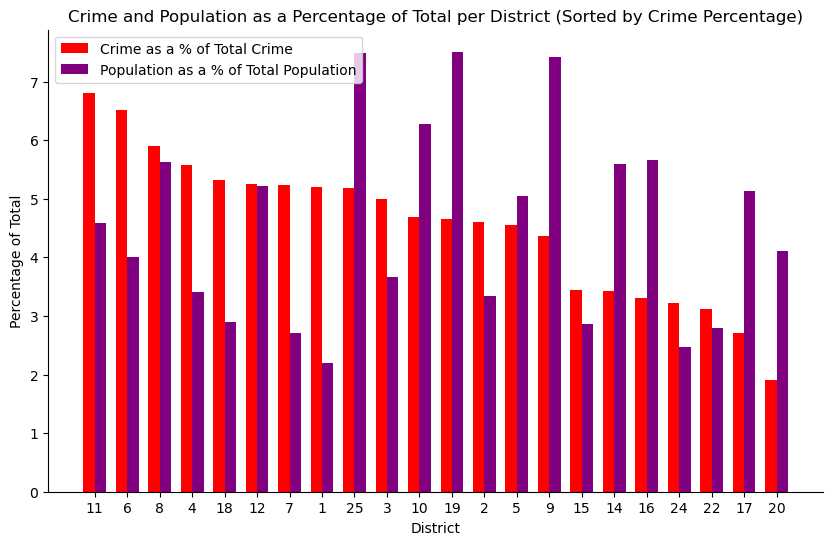

In [ ]:
# Recreate the graph above with better colors and labels
# Calculate the percentage of crime per total crime count for all districts
crime_percentage = cnt_per_district / cnt_per_district.sum() * 100

# Calculate the percentage of population per total population for all districts
population_percentage = pop_per_district / pop_per_district.sum() * 100

# Sort the data in descending order
crime_percentage_sorted = crime_percentage.sort_values(ascending=False)

# Set the bar width
bar_width = 0.35

# Set the x positions of the bars
x = np.arange(len(crime_percentage_sorted))

# Plot the figure
plt.figure(figsize=(10, 6))

# Plot the first bar chart, crime percentage as a percent of total percentage
plt.bar(x, crime_percentage_sorted, width = bar_width, label = "Crime Percentage as a Percent of Total Crime", color = "red")

# Plot the bars for population percentage as a percent of total population
plt.bar(x + bar_width, population_percentage_sorted, width = bar_width, label = "Population Percentage as a Percent of Total Population", color = "purple")

# Set the labels and title
plt.xlabel("District")
plt.ylabel("Percentage of Total")
plt.title("Crime and Population as a Percentage of Total per District (Sorted by Crime Percentage)")

# Set the x-axis tick positions and labels
plt.xticks(x + bar_width / 2, crime_percentage_sorted.index)

# Remove the top and right borders
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Add a legend
plt.legend(["Crime as a % of Total Crime", "Population as a % of Total Population"], loc = "upper left")

## Save the figure
plt.savefig("Images/PopulationandCrimeasaPercentofTotalFinal.png")

# Display the plot
plt.show()

In [ ]:
# Create a map that plots all crimes on a map with the color of the marker changing based on the number of crimes per district

# Group by district, and take the mean latitude and longitude to get the center of the district on the map, and count the number of 
# primary types of crimes in each district
grouped = final_df.groupby("District").agg(
    Latitude=("Latitude", "mean"),
    Longitude=("Longitude", "mean"),
    num_crimes=("Primary Type", "size"),
    # Pick one district number per population group
    district_name=("District", lambda x: x.unique()[0])
).reset_index()

# Configure the map plot
city_map = grouped.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    frame_width = 800,
    frame_height = 600,
    hover = True,
    size = 1500,
    ylabel = "Latitude",
    xlabel = "Longitude",
    color = "num_crimes",
    tiles = "OSM",
    alpha = .75,
    hover_cols = ["district_name"],
    clabel = "Number of Crimes"
) 

# Display the map
city_map

# # Save the map
# hvplot.save(city_map, 'mapfinal.png', fmt = "png")





:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (num_crimes,district_name)

In [ ]:
# Create a map that plots all crimes on a mapon a map with the size of the marker changing based on the number of crimes per district, as well
# as the color of the marker changing by number of crimes per district

# Group by district, and take the mean latitude and longitude to get the center of the district on the map, and count the number of 
# primary types of crimes in each district
# Aggregate the data
grouped = final_df.groupby("District").agg({"Latitude" : "mean", "Longitude" : "mean", "Primary Type" : "size"}).reset_index()
# Rename Primary Type to number_crimes for clarity
grouped = grouped.rename(columns = {"Primary Type" : "number_crimes"})

# Scale the number of crimes per district down for the map to appear more legible, but keep the proportionality of the crime rates 
# per district the same.  These scaled values will be between 0 and 1, by using the max-scaling method.
# Pick a scaling factor that will make the markers appear an appropriate size on the map
scaling_factor = 1000

# Take the max size of each of the district's number of crimes
max_size = grouped["number_crimes"].max()

# Create a new column, scaled_size, by dividing each number of crimes data by max size, then multiply it by the scaling factor
grouped["scaled_size"] = grouped["number_crimes"] / max_size * scaling_factor

# Configure the map plot
city_map = grouped.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    frame_width = 800,
    frame_height = 600,
    hover = True,
    size = "scaled_size",
    ylabel = "Latitude",
    xlabel = "Longitude",
    color = "number_crimes",
    tiles = "OSM",
    alpha = .85,
    hover_col = ["District"],
    legend = "right"
)

# Display the map
city_map

# # Save the map
# hvplot.save(city_map, 'mapsize.png', fmt = "png")

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (number_crimes,scaled_size)

#   2) Are certain areas more prone to crime than others? FURTHER ANALYSIS END


#   3) How has crime changed over time? START

In [ ]:
# Import Dependencies

import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from pathlib import Path

In [91]:
# Read in cleaned data from csv

crime_data_csv = Path("../../chicago_crimes_all_cleaned_final.csv")

crime_df = pd.read_csv(crime_data_csv)

crime_df

,Case Number,Date,Block,Primary Type,Description,District,Ward,Year,Latitude,Longitude,Location,Population,Zipcode
0,JC104662,12/31/2018 11:59:00 PM,112XX S SACRAMENTO AVE,MINOR PROPERTY CRIME,TO VEHICLE,22,19.0,2018,41.689079,-87.696064,"(41.689078832, -87.696064026)",28804.0,60655.0
1,JC100043,12/31/2018 11:57:00 PM,084XX S SANGAMON ST,MINOR PROPERTY CRIME,TO PROPERTY,6,21.0,2018,41.740521,-87.647391,"(41.740520866, -87.647390719)",68096.0,60620.0
2,JC100006,12/31/2018 11:56:00 PM,018XX S ALLPORT ST,ASSAULT & BATTERY,AGG: HANDS/FIST/FEET NO/MINOR INJURY,12,25.0,2018,41.857068,-87.657625,"(41.857068095, -87.657625201)",79205.0,60608.0
3,JC100031,12/31/2018 11:55:00 PM,078XX S SANGAMON ST,ASSAULT & BATTERY,DOMESTIC BATTERY SIMPLE,6,17.0,2018,41.751914,-87.647717,"(41.75191443, -87.647716532)",68096.0,60620.0
4,JC100026,12/31/2018 11:49:00 PM,052XX W GLADYS AVE,ASSAULT & BATTERY,AGGRAVATED - HANDGUN,15,29.0,2018,41.875684,-87.760479,"(41.87568438, -87.760479356)",47712.0,60644.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145665,JF420379,9/16/2022 13:48,026XX N NARRAGANSETT AVE,THEFT (ALL TYPES),RETAIL THEFT,25,36.0,2022,41.928077,-87.785606,"(41.928076536, -87.785606186)",41309.0,60707.0
1145666,JF420478,9/1/2022 5:00,005XX W SURF ST,OTHER MINOR CRIMES,HARASSMENT BY TELEPHONE,19,44.0,2022,41.934305,-87.641485,"(41.934304581, -87.641484982)",72113.0,60657.0
1145667,JF420319,7/8/2022 0:00,114XX S PRAIRIE AVE,THEFT (ALL TYPES),FRAUD OR CONFIDENCE GAME,5,9.0,2022,41.685544,-87.616813,"(41.685543881, -87.616812541)",64489.0,60628.0
1145668,JF420102,9/27/2022 11:00,023XX E 70TH ST,THEFT (ALL TYPES),OVER $500,3,5.0,2022,41.768068,-87.567453,"(41.768068052, -87.567452932)",48973.0,60649.0


In [92]:
# crime_df = crime_df.astype({"Year" : object})

In [93]:
# Calculate crimes per year

crime_df["Year"].value_counts().sort_index

<bound method Series.sort_index of 2018    258966
2019    254518
2022    228855
2020    204271
2021    199060
Name: Year, dtype: int64>

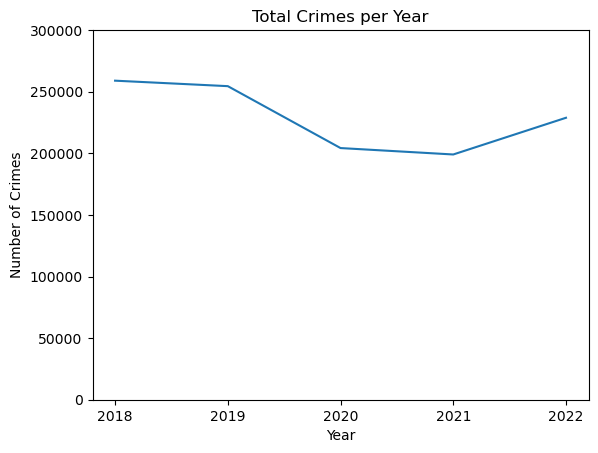

In [94]:
# Display total crimes per year

x_axis = crime_df["Year"].unique()
y_axis = crime_df["Year"].value_counts().sort_index()
plt.xticks(x_axis)
plt.title("Total Crimes per Year")
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.plot(x_axis, y_axis)
plt.ylim(0, 300000)

plt.savefig("Images/total.png")

In [95]:
# Create data frame grouped by type of crime and year

grouped_df = crime_df.groupby(["Primary Type", "Year"])[["Case Number"]].count().sort_values(by = ["Primary Type", "Year"], ascending = True)

# Display grouped data frame

grouped_df


Case Number
Primary Type                     Year             
ARSON                            2018          368
                                 2019          365
                                 2020          574
                                 2021          518
                                 2022          412
ASSAULT & BATTERY                2018        69401
                                 2019        69502
                                 2020        59087
                                 2021        60130
                                 2022        60979
DRUG RELATED                     2018        12696
                                 2019        14894
                                 2020         7227
                                 2021         4064
                                 2022         3938
HOMICIDE                         2018          598
                                 2019          499
                                 2020          789
                                 2021          804
                                 2022          716
KIDNAPPING AND HUMAN TRAFFICKING 2018          177
                                 2019          182
                                 2020          122
                                 2021           93
                                 2022          129
MINOR PROPERTY CRIME             2018        34041
                                 2019        32907
                                 2020        28405
                                 2021        27735
                                 2022        30540
NON-CRIMINAL (SUBJECT SPECIFIED) 2018            3
OFFENSE INVOLVING CHILDREN       2018         2152
                                 2019         2302
                                 2020         1835
                                 2021         1727
                                 2022         1775
OTHER MINOR CRIMES               2018        20614
                                 2019        20649
                                 2020        14572
                                 2021        14621
                                 2022        15613
SEXUAL RELATED CRIME             2018         2577
                                 2019         2846
                                 2020         2002
                                 2021         2386
                                 2022         2590
THEFT (ALL TYPES)                2018       110811
                                 2019       103874
                                 2020        81198
                                 2021        77976
                                 2022       103398
WEAPONS RELATED CRIME            2018         5528
                                 2019         6498
                                 2020         8460
                                 2021         9006
                                 2022         8765

In [96]:
# Set variables for the count of each type of crime by year

years = crime_df["Year"].unique()
theft_counts = grouped_df.iloc[46:51, 0]
assault_counts = grouped_df.iloc[5:10, 0]
property_counts = property_counts = grouped_df.iloc[25:30, 0]
minor_counts = grouped_df.iloc[36:41, 0]
drug_counts = grouped_df.iloc[10:15, 0]
weapons_counts = grouped_df.iloc[51:56, 0]
sexual_counts = grouped_df.iloc[41:46, 0]
children_counts = children_counts = grouped_df.iloc[31:36, 0]
homicide_counts = grouped_df.iloc[15:20, 0]
arson_counts = grouped_df.iloc[0:5, 0]
kidnapping_counts = grouped_df.iloc[20:25, 0]


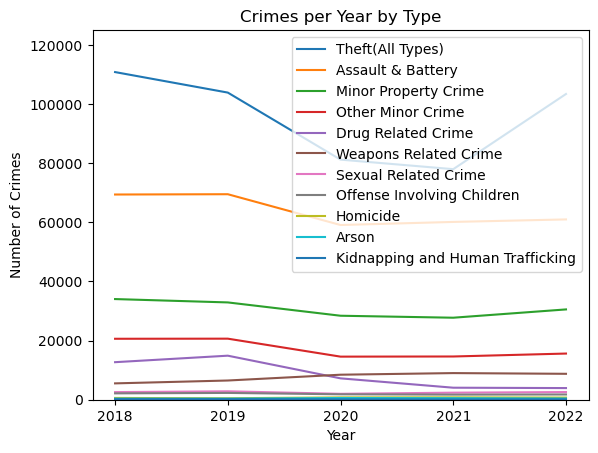

In [97]:
# Plot all types of crime by year

plt.plot(years, theft_counts, label="Theft(All Types)")
plt.plot(years, assault_counts, label="Assault & Battery")
plt.plot(years, property_counts, label="Minor Property Crime")
plt.plot(years, minor_counts, label="Other Minor Crime")
plt.plot(years, drug_counts, label="Drug Related Crime")
plt.plot(years, weapons_counts, label="Weapons Related Crime")
plt.plot(years, sexual_counts, label="Sexual Related Crime")
plt.plot(years, children_counts, label="Offense Involving Children")
plt.plot(years, homicide_counts, label="Homicide")
plt.plot(years, arson_counts, label="Arson")
plt.plot(years, kidnapping_counts, label="Kidnapping and Human Trafficking")
plt.xticks(years)
plt.title("Crimes per Year by Type")
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.ylim(0, 125000)
plt.legend(loc="best")
plt.savefig("Images/all_types.png")
plt.show()


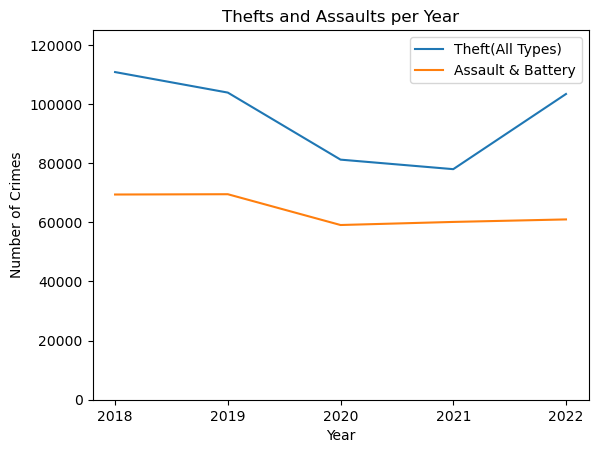

In [98]:
# Plot most common types of crime by year

plt.plot(years, theft_counts, label="Theft(All Types)")
plt.plot(years, assault_counts, label="Assault & Battery")
plt.xticks(years)
plt.title("Thefts and Assaults per Year")
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.ylim(0, 125000)
plt.legend(loc="best")
plt.savefig("Images/most_common.png")
plt.show()

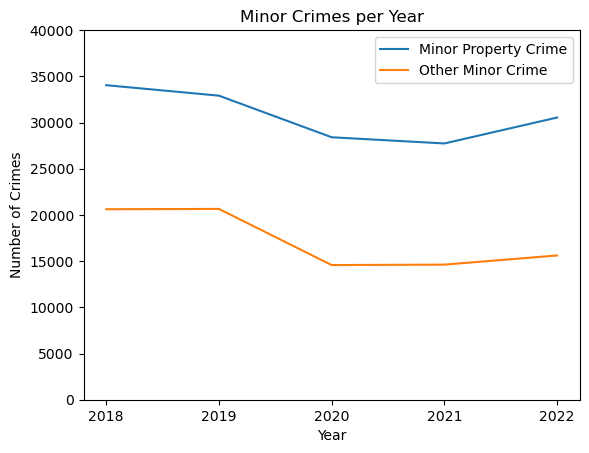

In [99]:
# Plot minor types of crime by year

plt.plot(years, property_counts, label="Minor Property Crime")
plt.plot(years, minor_counts, label="Other Minor Crime")
plt.xticks(years)
plt.title("Minor Crimes per Year")
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.ylim(0, 40000)
plt.legend(loc="best")
plt.savefig("Images/minor.png")
plt.show()

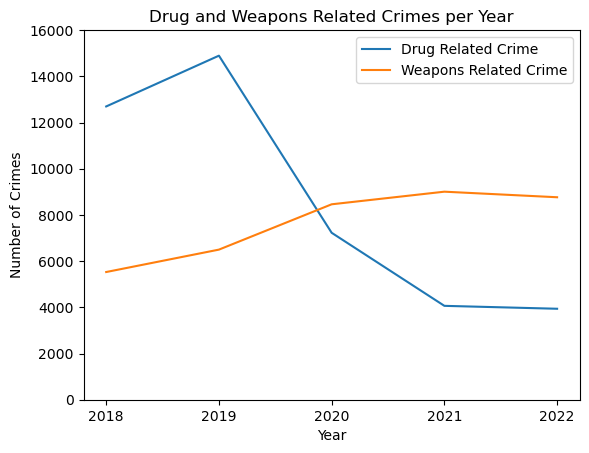

In [100]:
# Plot drug and weapons crime by year

plt.plot(years, drug_counts, label="Drug Related Crime")
plt.plot(years, weapons_counts, label="Weapons Related Crime")
plt.xticks(years)
plt.title("Drug and Weapons Related Crimes per Year")
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.ylim(0, 16000)
plt.legend(loc="best")
plt.savefig("Images/drugs_weapons.png")
plt.show()

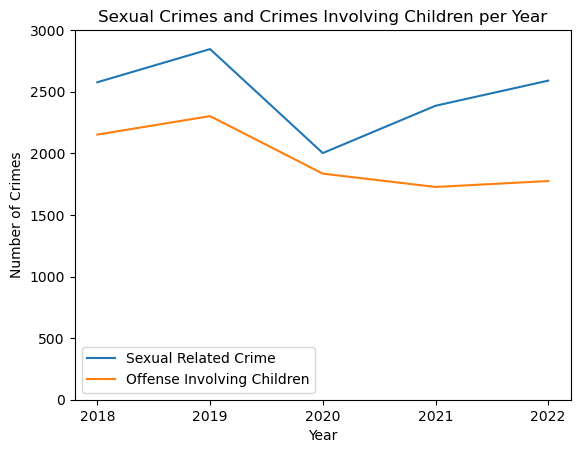

In [101]:
# Plot other types of crime by year

plt.plot(years, sexual_counts, label="Sexual Related Crime")
plt.plot(years, children_counts, label="Offense Involving Children")
plt.xticks(years)
plt.title("Sexual Crimes and Crimes Involving Children per Year")
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.ylim(0, 3000)
plt.legend(loc="best")
plt.savefig("Images/other.png")
plt.show()

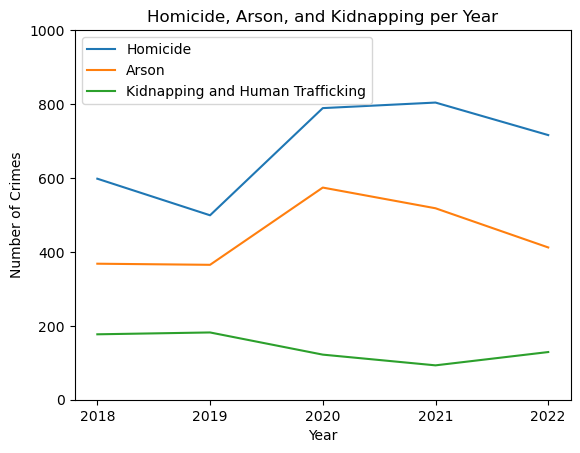

In [102]:
# Plot least common types of crime

plt.plot(years, homicide_counts, label="Homicide")
plt.plot(years, arson_counts, label="Arson")
plt.plot(years, kidnapping_counts, label="Kidnapping and Human Trafficking")
plt.xticks(years)
plt.title("Homicide, Arson, and Kidnapping per Year")
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.ylim(0, 1000)
plt.legend(loc="best")
plt.savefig("Images/least_common.png")
plt.show()

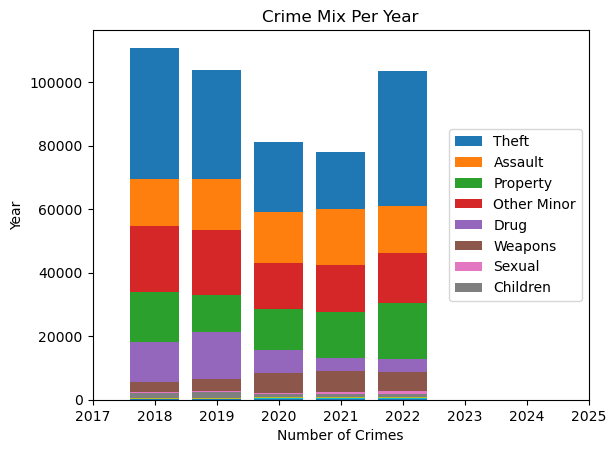

In [103]:
# Create stacked bar chart with crime types by year

plt.bar(years, theft_counts, label = "Theft")
plt.bar(years, assault_counts, label = "Assault")
plt.bar(years, property_counts, label = "Property")
plt.bar(years, minor_counts, bottom = property_counts, label = "Other Minor")
plt.bar(years, drug_counts, bottom = weapons_counts, label = "Drug")
plt.bar(years, weapons_counts, label= "Weapons")
plt.bar(years, sexual_counts, label = "Sexual")
plt.bar(years, children_counts, label = "Children")
plt.bar(years, homicide_counts)
plt.bar(years, arson_counts)
plt.bar(years, kidnapping_counts)
plt.xlim(2017, 2025)  
plt.legend(loc="right")
plt.title("Crime Mix Per Year")
plt.xlabel("Number of Crimes")
plt.ylabel("Year")
plt.savefig("Images/stacked_bar.png")
plt.show()

In [104]:
# Create new data frame with the totals by category by year

year_totals = pd.crosstab(index=crime_df['Year'], columns=crime_df['Primary Type'])

# Clean new data frame to put in same order as above bar chart

year_totals = year_totals[["THEFT (ALL TYPES)", "ASSAULT & BATTERY", "MINOR PROPERTY CRIME", "OTHER MINOR CRIMES", "DRUG RELATED", "WEAPONS RELATED CRIME",
                                     "SEXUAL RELATED CRIME", "OFFENSE INVOLVING CHILDREN", "HOMICIDE", "ARSON", "KIDNAPPING AND HUMAN TRAFFICKING"]]

year_totals

Primary Type,THEFT (ALL TYPES),ASSAULT & BATTERY,MINOR PROPERTY CRIME,OTHER MINOR CRIMES,DRUG RELATED,WEAPONS RELATED CRIME,SEXUAL RELATED CRIME,OFFENSE INVOLVING CHILDREN,HOMICIDE,ARSON,KIDNAPPING AND HUMAN TRAFFICKING
Year,,,,,,,,,,,
2018,110811,69401,34041,20614,12696,5528,2577,2152,598,368,177
2019,103874,69502,32907,20649,14894,6498,2846,2302,499,365,182
2020,81198,59087,28405,14572,7227,8460,2002,1835,789,574,122
2021,77976,60130,27735,14621,4064,9006,2386,1727,804,518,93
2022,103398,60979,30540,15613,3938,8765,2590,1775,716,412,129


In [105]:
# Reduce data frame to plot percentages of most common crimes

year_totals_reduced = year_totals[["THEFT (ALL TYPES)", "ASSAULT & BATTERY", "MINOR PROPERTY CRIME", "OTHER MINOR CRIMES"]]
year_totals_reduced

Primary Type,THEFT (ALL TYPES),ASSAULT & BATTERY,MINOR PROPERTY CRIME,OTHER MINOR CRIMES
Year,,,,
2018,110811,69401,34041,20614
2019,103874,69502,32907,20649
2020,81198,59087,28405,14572
2021,77976,60130,27735,14621
2022,103398,60979,30540,15613


In [106]:
# Create new data frame with the proportion by category by year

year_proportions = pd.crosstab(index=crime_df['Year'], columns=crime_df['Primary Type'], normalize="index")

# Clean new data frame to put in same order as above bar chart

year_proportions = year_proportions[["THEFT (ALL TYPES)", "ASSAULT & BATTERY", "MINOR PROPERTY CRIME", "OTHER MINOR CRIMES", "DRUG RELATED", "WEAPONS RELATED CRIME",
                                     "SEXUAL RELATED CRIME", "OFFENSE INVOLVING CHILDREN", "HOMICIDE", "ARSON", "KIDNAPPING AND HUMAN TRAFFICKING"]]
year_proportions

Primary Type,THEFT (ALL TYPES),ASSAULT & BATTERY,MINOR PROPERTY CRIME,OTHER MINOR CRIMES,DRUG RELATED,WEAPONS RELATED CRIME,SEXUAL RELATED CRIME,OFFENSE INVOLVING CHILDREN,HOMICIDE,ARSON,KIDNAPPING AND HUMAN TRAFFICKING
Year,,,,,,,,,,,
2018,0.427898,0.267993,0.131450,0.079601,0.049026,0.021346,0.009951,0.008310,0.002309,0.001421,0.000683
2019,0.408120,0.273073,0.129291,0.081130,0.058518,0.025531,0.011182,0.009045,0.001961,0.001434,0.000715
2020,0.397501,0.289258,0.139055,0.071337,0.035379,0.041416,0.009801,0.008983,0.003863,0.002810,0.000597
2021,0.391721,0.302070,0.139330,0.073450,0.020416,0.045243,0.011986,0.008676,0.004039,0.002602,0.000467
2022,0.451806,0.266453,0.133447,0.068222,0.017207,0.038299,0.011317,0.007756,0.003129,0.001800,0.000564


In [107]:
# Reduce data frame to plot percentages of most common crimes

year_proportions_reduced = year_proportions[["THEFT (ALL TYPES)", "ASSAULT & BATTERY", "MINOR PROPERTY CRIME", "OTHER MINOR CRIMES"]]

year_proportions_reduced


Primary Type,THEFT (ALL TYPES),ASSAULT & BATTERY,MINOR PROPERTY CRIME,OTHER MINOR CRIMES
Year,,,,
2018,0.427898,0.267993,0.131450,0.079601
2019,0.408120,0.273073,0.129291,0.081130
2020,0.397501,0.289258,0.139055,0.071337
2021,0.391721,0.302070,0.139330,0.073450
2022,0.451806,0.266453,0.133447,0.068222


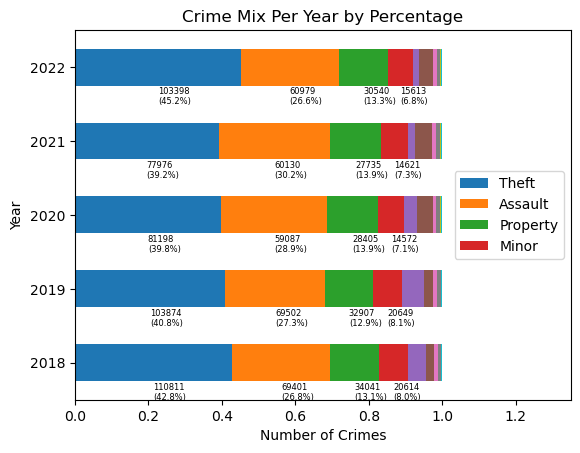

In [108]:
# Graph crime mix as a percentage of the total

year_proportions.plot(kind="barh", stacked=True)
for n, x in enumerate([*year_totals_reduced.index.values]):
    for (proportion, count, y_loc) in zip(year_proportions_reduced.loc[x],
                                          year_totals_reduced.loc[x],
                                          year_proportions_reduced.loc[x].cumsum()):
                
        plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.5,
                 s=f'{count}\n({np.round(proportion * 100, 1)}%)', 
                 fontsize=6)
plt.xlim(0, 1.35)  
plt.legend(["Theft", "Assault", "Property", "Minor"], loc="right")
plt.title("Crime Mix Per Year by Percentage")
plt.xlabel("Number of Crimes")
plt.ylabel("Year")
plt.savefig("Images/percentage_bar.png")

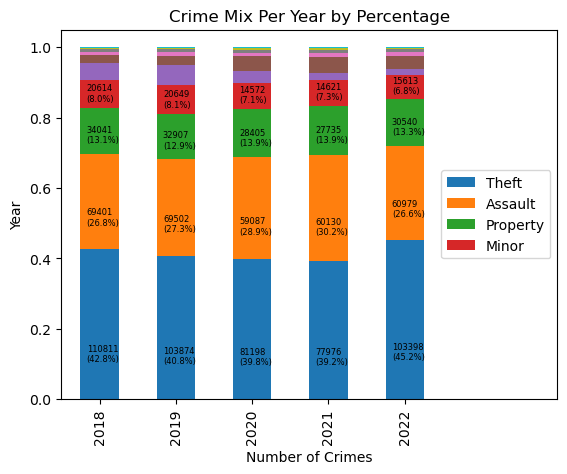

In [109]:
# Verical version of above chart

year_proportions.plot(kind="bar", stacked=True)
for n, x in enumerate([*year_totals_reduced.index.values]):
    for (proportion, count, y_loc) in zip(year_proportions_reduced.loc[x],
                                          year_totals_reduced.loc[x],
                                          year_proportions_reduced.loc[x].cumsum()):
                
        plt.text(x=n - 0.17,
                 y=(y_loc - proportion) + (proportion / 4),
                 s=f'{count}\n({np.round(proportion * 100, 1)}%)',
                 fontsize=6)
plt.xlim(-.5, 6)  
plt.legend(["Theft", "Assault", "Property", "Minor"], loc="right")
plt.title("Crime Mix Per Year by Percentage")
plt.xlabel("Number of Crimes")
plt.ylabel("Year")
plt.savefig("Images/percentage_bar_vert.png")

In [110]:
# Calculate % change over the entire time frame for each category

year_cat = year_totals = pd.crosstab(index=crime_df['Primary Type'], columns=crime_df['Year'])
year_cat["Total"] = crime_df["Primary Type"].value_counts()
year_cat["Change 2018-2022"] = year_cat[2022] - year_cat[2018]
year_cat["% Change 2018-2022"] = (year_cat["Change 2018-2022"] / year_cat[2018]) * 100
year_cat = year_cat.drop(index = "NON-CRIMINAL (SUBJECT SPECIFIED)")

year_cat

Year,2018,2019,2020,2021,2022,Total,Change 2018-2022,% Change 2018-2022
Primary Type,,,,,,,,
ARSON,368,365,574,518,412,2237,44,11.956522
ASSAULT & BATTERY,69401,69502,59087,60130,60979,319099,-8422,-12.135272
DRUG RELATED,12696,14894,7227,4064,3938,42819,-8758,-68.982357
HOMICIDE,598,499,789,804,716,3406,118,19.732441
KIDNAPPING AND HUMAN TRAFFICKING,177,182,122,93,129,703,-48,-27.118644
MINOR PROPERTY CRIME,34041,32907,28405,27735,30540,153628,-3501,-10.284657
OFFENSE INVOLVING CHILDREN,2152,2302,1835,1727,1775,9791,-377,-17.518587
OTHER MINOR CRIMES,20614,20649,14572,14621,15613,86069,-5001,-24.260212
SEXUAL RELATED CRIME,2577,2846,2002,2386,2590,12401,13,0.504463


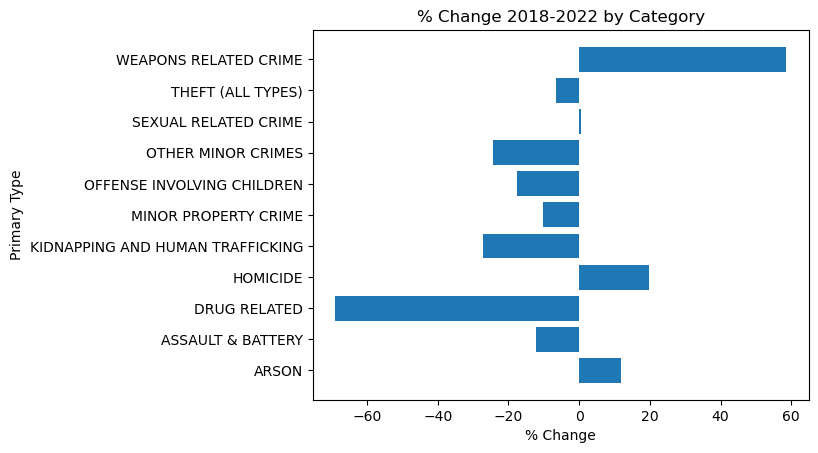

In [111]:
# Plot % change over the entire time frame for each category

types = year_cat.index
change = year_cat["% Change 2018-2022"]

plt.barh(types, change)
plt.title("% Change 2018-2022 by Category")
plt.xlabel("% Change")
plt.ylabel("Primary Type")
plt.savefig("Images/percent_change_cat.png")
plt.show()

In [112]:
# Calculate change in total crime for each year

year_change = year_cat.append(crime_df["Year"].value_counts())
year_change["2019 % Change"] = ((year_change[2019] - year_change[2018]) / year_change[2018]) * 100
year_change["2020 % Change"] = ((year_change[2020] - year_change[2019]) / year_change[2019]) * 100
year_change["2021 % Change"] = ((year_change[2021] - year_change[2020]) / year_change[2020]) * 100
year_change["2022 % Change"] = ((year_change[2022] - year_change[2021]) / year_change[2021]) * 100
year_change = year_change[["2019 % Change", "2020 % Change", "2021 % Change", "2022 % Change"]]
year_change


Year,2019 % Change,2020 % Change,2021 % Change,2022 % Change
Primary Type,,,,
ARSON,-0.815217,57.260274,-9.756098,-20.463320
ASSAULT & BATTERY,0.145531,-14.985180,1.765194,1.411941
DRUG RELATED,17.312539,-51.477105,-43.766431,-3.100394
HOMICIDE,-16.555184,58.116232,1.901141,-10.945274
KIDNAPPING AND HUMAN TRAFFICKING,2.824859,-32.967033,-23.770492,38.709677
MINOR PROPERTY CRIME,-3.331277,-13.680980,-2.358740,10.113575
OFFENSE INVOLVING CHILDREN,6.970260,-20.286707,-5.885559,2.779386
OTHER MINOR CRIMES,0.169788,-29.429997,0.336261,6.784762
SEXUAL RELATED CRIME,10.438494,-29.655657,19.180819,8.549874


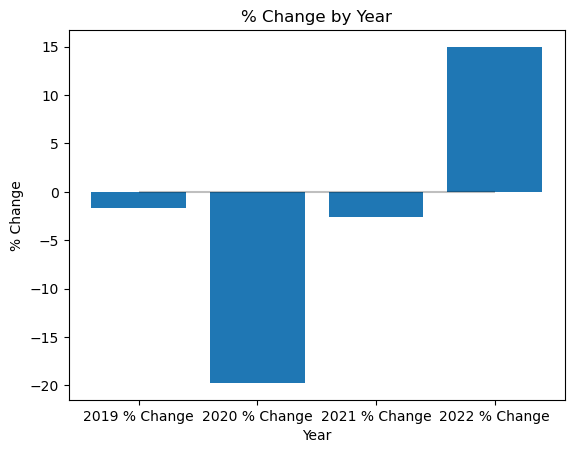

In [113]:
# Plot change in total crime for each year

changes = year_change.iloc[11, :]
x_axis = year_change.columns

plt.bar(x_axis, changes)
plt.title("% Change by Year")
plt.xlabel("Year")
plt.ylabel("% Change")
plt.hlines(0, 0 , 3, alpha=0.25)
plt.savefig("Images/percent_change_total.png")
plt.show()


#   3) How has crime changed over time? END

#   4) How common is extremely violent crime? START

In [1]:
#import dependencies
import os
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import dataframe_image as dfi
from pandas import option_context

# chicago crime data file
crime_path = "Resources/chicago_crimes_all_cleaned.csv"

# Read the mouse data and put into a dataframe
crime = pd.read_csv(crime_path)
crime_df = pd.DataFrame(crime)

# Display the data table for preview
crime_df.head()

,Case Number,Date,Block,Primary Type,Description,District,Ward,Year,Latitude,Longitude,Location,Population,Zipcode
0,JC104662,12/31/2018 11:59:00 PM,112XX S SACRAMENTO AVE,MINOR PROPERTY CRIME,TO VEHICLE,22,19.0,2018,41.689079,-87.696064,"(41.689078832, -87.696064026)",28804.0,60655.0
1,JC100043,12/31/2018 11:57:00 PM,084XX S SANGAMON ST,MINOR PROPERTY CRIME,TO PROPERTY,6,21.0,2018,41.740521,-87.647391,"(41.740520866, -87.647390719)",68096.0,60620.0
2,JC100006,12/31/2018 11:56:00 PM,018XX S ALLPORT ST,ASSAULT & BATTERY,AGG: HANDS/FIST/FEET NO/MINOR INJURY,12,25.0,2018,41.857068,-87.657625,"(41.857068095, -87.657625201)",79205.0,60608.0
3,JC100031,12/31/2018 11:55:00 PM,078XX S SANGAMON ST,ASSAULT & BATTERY,DOMESTIC BATTERY SIMPLE,6,17.0,2018,41.751914,-87.647717,"(41.75191443, -87.647716532)",68096.0,60620.0
4,JC100026,12/31/2018 11:49:00 PM,052XX W GLADYS AVE,ASSAULT & BATTERY,AGGRAVATED - HANDGUN,15,29.0,2018,41.875684,-87.760479,"(41.87568438, -87.760479356)",47712.0,60644.0


In [2]:
#get data types for formatting later
crime_df.dtypes

Case Number      object
Date             object
Block            object
Primary Type     object
Description      object
District          int64
Ward            float64
Year              int64
Latitude        float64
Longitude       float64
Location         object
Population      float64
Zipcode         float64
dtype: object

In [3]:
#list all the columns available in the df
crime_df.columns

Index(['Case Number', 'Date', 'Block', 'Primary Type', 'Description',
       'District', 'Ward', 'Year', 'Latitude', 'Longitude', 'Location',
       'Population', 'Zipcode'],
      dtype='object')

In [4]:
#remove unnecessary columns
crime_cleaned_df = crime_df[["Case Number", "Date", "Block", "Primary Type", "Description", "District", "Ward",
                                     "Year", "Latitude", "Longitude","Population","Zipcode"]]
crime_cleaned_df.head()

,Case Number,Date,Block,Primary Type,Description,District,Ward,Year,Latitude,Longitude,Population,Zipcode
0,JC104662,12/31/2018 11:59:00 PM,112XX S SACRAMENTO AVE,MINOR PROPERTY CRIME,TO VEHICLE,22,19.0,2018,41.689079,-87.696064,28804.0,60655.0
1,JC100043,12/31/2018 11:57:00 PM,084XX S SANGAMON ST,MINOR PROPERTY CRIME,TO PROPERTY,6,21.0,2018,41.740521,-87.647391,68096.0,60620.0
2,JC100006,12/31/2018 11:56:00 PM,018XX S ALLPORT ST,ASSAULT & BATTERY,AGG: HANDS/FIST/FEET NO/MINOR INJURY,12,25.0,2018,41.857068,-87.657625,79205.0,60608.0
3,JC100031,12/31/2018 11:55:00 PM,078XX S SANGAMON ST,ASSAULT & BATTERY,DOMESTIC BATTERY SIMPLE,6,17.0,2018,41.751914,-87.647717,68096.0,60620.0
4,JC100026,12/31/2018 11:49:00 PM,052XX W GLADYS AVE,ASSAULT & BATTERY,AGGRAVATED - HANDGUN,15,29.0,2018,41.875684,-87.760479,47712.0,60644.0


In [5]:
#split the cleaned data into dataframes by year for finding total population counts by year
df_2018 = crime_cleaned_df[crime_cleaned_df["Year"]==2018]
df_2019 = crime_cleaned_df[crime_cleaned_df["Year"]==2019]
df_2020 = crime_cleaned_df[crime_cleaned_df["Year"]==2020]
df_2021 = crime_cleaned_df[crime_cleaned_df["Year"]==2021]
df_2022 = crime_cleaned_df[crime_cleaned_df["Year"]==2022]

In [6]:
#create a dataframe containing the population for each year
years = crime_cleaned_df["Year"].unique()
population = [df_2018.groupby("Zipcode")["Population"].unique().sum().sum(),
              df_2019.groupby("Zipcode")["Population"].unique().sum().sum(),
              df_2020.groupby("Zipcode")["Population"].unique().sum().sum(),
              df_2021.groupby("Zipcode")["Population"].unique().sum().sum(),
              df_2022.groupby("Zipcode")["Population"].unique().sum().sum()]
pop_average = np.array(population).mean()
pop_by_year = {years[0]:population[0],years[1]:population[1],
               years[2]:population[2],years[3]:population[3],
               years[4]:population[4],"Average":pop_average}
pop_no_average = {years[0]:population[0],years[1]:population[1],
               years[2]:population[2],years[3]:population[3],
               years[4]:population[4]}


In [7]:
#get the counts of the "Primary Type" of crime committed
counts_crime = crime_cleaned_df["Primary Type"].value_counts()
counts_crime

THEFT (ALL TYPES)                   477257
ASSAULT & BATTERY                   319099
MINOR PROPERTY CRIME                153628
OTHER MINOR CRIMES                   86069
DRUG RELATED                         42819
WEAPONS RELATED CRIME                38257
SEXUAL RELATED CRIME                 12401
OFFENSE INVOLVING CHILDREN            9791
HOMICIDE                              3406
ARSON                                 2237
KIDNAPPING AND HUMAN TRAFFICKING       703
NON-CRIMINAL (SUBJECT SPECIFIED)         3
Name: Primary Type, dtype: int64

In [8]:
# Group categories of crime by year
types_grouped = crime_cleaned_df.groupby(["Primary Type","Year"])[["Case Number"]].count().sort_values(by=["Primary Type","Year"])
types_df = pd.DataFrame(types_grouped)
types_df.head()

Case Number
Primary Type Year             
ARSON        2018          368
             2019          365
             2020          574
             2021          518
             2022          412

In [9]:
#Get counts by year for each type and put into dictionaries
arson_count = types_df.loc["ARSON","Case Number"]
arson = dict(arson_count)
total_arson = arson_count.sum()
arson["Totals"]=total_arson
assault_count = types_df.loc["ASSAULT & BATTERY","Case Number"]
assault = dict(assault_count)
total_assault = assault_count.sum()
assault["Totals"]=total_assault
drug_count = types_df.loc["DRUG RELATED","Case Number"]
drug = dict(drug_count)
total_drug = drug_count.sum()
drug["Totals"]=total_drug
homicide_count = types_df.loc["HOMICIDE","Case Number"]
homicide = dict(homicide_count)
total_homicide = homicide_count.sum()
homicide["Totals"]=total_homicide
kidnap_count = types_df.loc["KIDNAPPING AND HUMAN TRAFFICKING","Case Number"]
kidnap = dict(kidnap_count)
total_kidnap = kidnap_count.sum()
kidnap["Totals"]=total_kidnap
non_crim_count = types_df.loc["NON-CRIMINAL (SUBJECT SPECIFIED)","Case Number"]
non_crim = dict(non_crim_count)
total_non_crim = non_crim_count.sum()
non_crim["Totals"]=total_non_crim
children_count = types_df.loc["OFFENSE INVOLVING CHILDREN","Case Number"]
children = dict(children_count)
total_children = children_count.sum()
children["Totals"]=total_children
other_minor_count = types_df.loc["OTHER MINOR CRIMES","Case Number"]
other_minor = dict(other_minor_count)
total_other_minor = other_minor_count.sum()
other_minor["Totals"]=total_other_minor
sex_crime_count = types_df.loc["SEXUAL RELATED CRIME","Case Number"]
sex_crime = dict(sex_crime_count)
total_sex_crime = sex_crime_count.sum()
sex_crime["Totals"]=total_sex_crime
theft_count = types_df.loc["THEFT (ALL TYPES)","Case Number"]
theft = dict(theft_count)
total_theft = theft_count.sum()
theft["Totals"]=total_theft
weapons_count = types_df.loc["WEAPONS RELATED CRIME","Case Number"]
weapons = dict(weapons_count)
total_weapons = weapons_count.sum()
weapons["Totals"]=total_weapons


In [10]:
#get value count arrays for each year and for totals
counts_crime = crime_cleaned_df["Year"].value_counts().sort_index()
crime_counts = counts_crime.to_dict()
crime_counts["Totals"] = counts_crime.sum()


In [11]:
#create a df of all the counts by type and year
clean_types = {"Arson":arson,"Assault":assault,
               "Drug Crime":drug,"Homicide":homicide,
               "Kidnapping":kidnap,
               "Non-criminal":non_crim,
               "Children":children,
               "Other":other_minor,
               "Sex Crime":sex_crime,
               "Theft":theft,
               "Weapons":weapons,
               "All Crimes":crime_counts}
clean_types_df = pd.DataFrame(clean_types)

#format the values to have commas
clean_types_df["Arson"] = clean_types_df["Arson"].map("{:,.0f}".format)
clean_types_df["Assault"] = clean_types_df["Assault"].map("{:,.0f}".format)
clean_types_df["Drug Crime"] = clean_types_df["Drug Crime"].map("{:,.0f}".format)
clean_types_df["Homicide"] = clean_types_df["Homicide"].map("{:,.0f}".format)
clean_types_df["Non-criminal"] = clean_types_df["Non-criminal"].map("{:,.0f}".format)
clean_types_df["Children"] = clean_types_df["Children"].map("{:,.0f}".format)
clean_types_df["Other"] = clean_types_df["Other"].map("{:,.0f}".format)
clean_types_df["Sex Crime"] = clean_types_df["Sex Crime"].map("{:,.0f}".format)
clean_types_df["Theft"] = clean_types_df["Theft"].map("{:,.0f}".format)
clean_types_df["Weapons"] = clean_types_df["Weapons"].map("{:,.0f}".format)
clean_types_df["All Crimes"] = clean_types_df["All Crimes"].map("{:,.0f}".format)

dfi.export(clean_types_df,'Images/typecounts_df_all.png',table_conversion='matplotlib')
clean_types_df


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


,Arson,Assault,Drug Crime,Homicide,Kidnapping,Non-criminal,Children,Other,Sex Crime,Theft,Weapons,All Crimes
2018,368,"69,401","12,696",598,177,3,"2,152","20,614","2,577","110,811","5,528","258,966"
2019,365,"69,502","14,894",499,182,nan,"2,302","20,649","2,846","103,874","6,498","254,518"
2020,574,"59,087","7,227",789,122,nan,"1,835","14,572","2,002","81,198","8,460","204,271"
2021,518,"60,130","4,064",804,93,nan,"1,727","14,621","2,386","77,976","9,006","199,060"
2022,412,"60,979","3,938",716,129,nan,"1,775","15,613","2,590","103,398","8,765","228,855"
Totals,"2,237","319,099","42,819","3,406",703,3,"9,791","86,069","12,401","477,257","38,257","1,145,670"


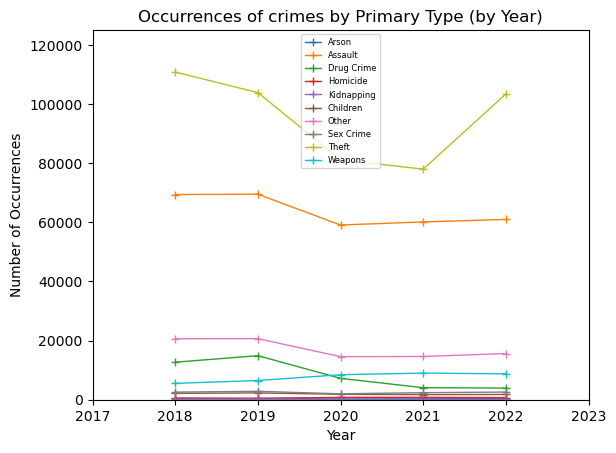

In [12]:
#add a time series for the raw count of all types
years = crime_cleaned_df["Year"].unique()
plt.plot(years,arson_count,marker="+",linewidth=1,label="Arson")
plt.plot(years,assault_count,marker="+",linewidth=1,label="Assault")
plt.plot(years,drug_count,marker="+",linewidth=1,label="Drug Crime")
plt.plot(years,homicide_count,marker="+",linewidth=1,label="Homicide")
plt.plot(years,kidnap_count,marker="+",linewidth=1,label="Kidnapping")
plt.plot(years,children_count,marker="+",linewidth=1,label="Children")
plt.plot(years,other_minor_count,marker="+",linewidth=1,label="Other")
plt.plot(years,sex_crime_count,marker="+",linewidth=1,label="Sex Crime")
plt.plot(years,theft_count,marker="+",linewidth=1,label="Theft")
plt.plot(years,weapons_count,marker="+",linewidth=1,label="Weapons")
plt.xlim(2017,2023)
plt.ylim(0,125000)
plt.title("Occurrences of crimes by Primary Type (by Year)")
plt.xlabel("Year")
plt.ylabel("Number of Occurrences")
plt.legend(fontsize = 6,loc='upper center')
plt.savefig("Images/count_all_types.png")
plt.show()

In [13]:
#redefine clean_types_df with original formatting
clean_types = {"Arson":arson,"Assault":assault,
               "Drug Crime":drug,"Homicide":homicide,
               "Kidnapping":kidnap,
               "Non-criminal":non_crim,
               "Children":children,
               "Other":other_minor,
               "Sex Crime":sex_crime,
               "Theft":theft,
               "Weapons":weapons,
               "All Crimes":crime_counts}
clean_types_df = pd.DataFrame(clean_types)

#convert yearly counts into percentages of crime committed that year
arson_percent = (clean_types_df["Arson"]/clean_types_df["All Crimes"])*100
assault_percent = (clean_types_df["Assault"]/clean_types_df["All Crimes"])*100
drug_percent = (clean_types_df["Drug Crime"]/clean_types_df["All Crimes"])*100
homicide_percent = (clean_types_df["Homicide"]/clean_types_df["All Crimes"])*100
kidnap_percent = (clean_types_df["Kidnapping"]/clean_types_df["All Crimes"])*100
non_crim_percent = (clean_types_df["Non-criminal"]/clean_types_df["All Crimes"])*100
children_percent = (clean_types_df["Children"]/clean_types_df["All Crimes"])*100
other_minor_percent = (clean_types_df["Other"]/clean_types_df["All Crimes"])*100
sex_crime_percent = (clean_types_df["Sex Crime"]/clean_types_df["All Crimes"])*100
theft_percent = (clean_types_df["Theft"]/clean_types_df["All Crimes"])*100
weapon_percent = (clean_types_df["Weapons"]/clean_types_df["All Crimes"])*100


In [14]:
#organize into a dictionary called types_percent
types_percent = {"Arson":arson_percent,"Assault":assault_percent,
               "Drug Crime":drug_percent,"Homicide":homicide_percent,
               "Kidnapping":kidnap_percent,
               "Non-criminal":non_crim_percent,
               "Children":children_percent,
               "Other":other_minor_percent,
               "Sex Crime":sex_crime_percent,
               "Theft":theft_percent,
               "Weapons":weapon_percent}
#create a dataframe from the dictionary
types_percent_df = pd.DataFrame(types_percent)

#format values into percentages (%)
types_percent_df["Arson"] = types_percent_df["Arson"].map("{:,.4f}%".format)
types_percent_df["Assault"] = types_percent_df["Assault"].map("{:,.4f}%".format)
types_percent_df["Drug Crime"] = types_percent_df["Drug Crime"].map("{:,.4f}%".format)
types_percent_df["Homicide"] = types_percent_df["Homicide"].map("{:,.4f}%".format)
types_percent_df["Kidnapping"] = types_percent_df["Kidnapping"].map("{:,.4f}%".format)
types_percent_df["Non-criminal"] = types_percent_df["Non-criminal"].map("{:,.4f}%".format)
types_percent_df["Children"] = types_percent_df["Children"].map("{:,.4f}%".format)
types_percent_df["Other"] = types_percent_df["Other"].map("{:,.4f}%".format)
types_percent_df["Sex Crime"] = types_percent_df["Sex Crime"].map("{:,.4f}%".format)
types_percent_df["Theft"] = types_percent_df["Theft"].map("{:,.4f}%".format)
types_percent_df["Weapons"] = types_percent_df["Weapons"].map("{:,.4f}%".format)

#save file as png in resources
dfi.export(types_percent_df,'Images/type_percent_df_all.png',table_conversion='matplotlib')
#display the dataframe
types_percent_df


,Arson,Assault,Drug Crime,Homicide,Kidnapping,Non-criminal,Children,Other,Sex Crime,Theft,Weapons
2018,0.1421%,26.7993%,4.9026%,0.2309%,0.0683%,0.0012%,0.8310%,7.9601%,0.9951%,42.7898%,2.1346%
2019,0.1434%,27.3073%,5.8518%,0.1961%,0.0715%,nan%,0.9045%,8.1130%,1.1182%,40.8120%,2.5531%
2020,0.2810%,28.9258%,3.5379%,0.3863%,0.0597%,nan%,0.8983%,7.1337%,0.9801%,39.7501%,4.1416%
2021,0.2602%,30.2070%,2.0416%,0.4039%,0.0467%,nan%,0.8676%,7.3450%,1.1986%,39.1721%,4.5243%
2022,0.1800%,26.6453%,1.7207%,0.3129%,0.0564%,nan%,0.7756%,6.8222%,1.1317%,45.1806%,3.8299%
Totals,0.1953%,27.8526%,3.7375%,0.2973%,0.0614%,0.0003%,0.8546%,7.5125%,1.0824%,41.6575%,3.3393%


In [15]:
#redefine the percentage formulas without the last row (totals)
years_types = {"Arson":arson_count,"Assault":assault_count,
               "Drug Crime":drug_count,"Homicide":homicide_count,
               "Kidnapping":kidnap_count,
               "Non-criminal":non_crim_count,
               "Children":children_count,
               "Other":other_minor_count,
               "Sex Crime":sex_crime_count,
               "Theft":theft_count,
               "Weapons":weapons_count,
               "All Crimes":counts_crime}
years_types_df = pd.DataFrame(years_types)

#convert yearly counts into percentages of crime committed that year
arson_percent_years = (years_types_df["Arson"]/years_types_df["All Crimes"])*100
assault_percent_years = (years_types_df["Assault"]/years_types_df["All Crimes"])*100
drug_percent_years = (years_types_df["Drug Crime"]/years_types_df["All Crimes"])*100
homicide_percent_years = (years_types_df["Homicide"]/years_types_df["All Crimes"])*100
kidnap_percent_years = (years_types_df["Kidnapping"]/years_types_df["All Crimes"])*100
non_crim_percent_years = (years_types_df["Non-criminal"]/years_types_df["All Crimes"])*100
children_percent_years = (years_types_df["Children"]/years_types_df["All Crimes"])*100
other_minor_percent_years = (years_types_df["Other"]/years_types_df["All Crimes"])*100
sex_crime_percent_years = (years_types_df["Sex Crime"]/years_types_df["All Crimes"])*100
theft_percent_years = (years_types_df["Theft"]/years_types_df["All Crimes"])*100
weapon_percent_years = (years_types_df["Weapons"]/years_types_df["All Crimes"])*100


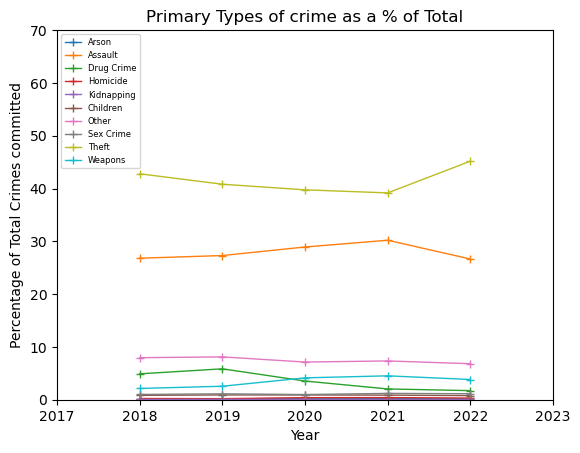

In [16]:
#add a time series for the percentages by year
years = crime_cleaned_df["Year"].unique()
plt.plot(years,arson_percent_years,marker="+",linewidth=1,label="Arson")
plt.plot(years,assault_percent_years,marker="+",linewidth=1,label="Assault")
plt.plot(years,drug_percent_years,marker="+",linewidth=1,label="Drug Crime")
plt.plot(years,homicide_percent_years,marker="+",linewidth=1,label="Homicide")
plt.plot(years,kidnap_percent_years,marker="+",linewidth=1,label="Kidnapping")
plt.plot(years,children_percent_years,marker="+",linewidth=1,label="Children")
plt.plot(years,other_minor_percent_years,marker="+",linewidth=1,label="Other")
plt.plot(years,sex_crime_percent_years,marker="+",linewidth=1,label="Sex Crime")
plt.plot(years,theft_percent_years,marker="+",linewidth=1,label="Theft")
plt.plot(years,weapon_percent_years,marker="+",linewidth=1,label="Weapons")
plt.xlim(2017,2023)
plt.ylim(0,70)
plt.title("Primary Types of crime as a % of Total")
plt.xlabel("Year")
plt.ylabel("Percentage of Total Crimes committed")
plt.legend(fontsize = 6,loc='best')
plt.savefig("Images/percent_all_types.png")
plt.show()


In [17]:
#redefine counts by year to get the mean for the 'totals column
arson_count = types_df.loc["ARSON","Case Number"]
arson = dict(arson_count)
mean_arson = arson_count.mean()
arson["Average"]=mean_arson
assault_count = types_df.loc["ASSAULT & BATTERY","Case Number"]
assault = dict(assault_count)
mean_assault = assault_count.mean()
assault["Average"]=mean_assault
drug_count = types_df.loc["DRUG RELATED","Case Number"]
drug = dict(drug_count)
mean_drug = drug_count.mean()
drug["Average"]=mean_drug
homicide_count = types_df.loc["HOMICIDE","Case Number"]
homicide = dict(homicide_count)
mean_homicide = homicide_count.mean()
homicide["Average"]=mean_homicide
kidnap_count = types_df.loc["KIDNAPPING AND HUMAN TRAFFICKING","Case Number"]
kidnap = dict(kidnap_count)
mean_kidnap = kidnap_count.mean()
kidnap["Average"]=mean_kidnap
non_crim_count = types_df.loc["NON-CRIMINAL (SUBJECT SPECIFIED)","Case Number"]
non_crim = dict(non_crim_count)
mean_non_crim = non_crim_count.mean()
non_crim["Average"]=mean_non_crim
children_count = types_df.loc["OFFENSE INVOLVING CHILDREN","Case Number"]
children = dict(children_count)
mean_children = children_count.mean()
children["Average"]=mean_children
other_minor_count = types_df.loc["OTHER MINOR CRIMES","Case Number"]
other_minor = dict(other_minor_count)
mean_other_minor = other_minor_count.mean()
other_minor["Average"]=mean_other_minor
sex_crime_count = types_df.loc["SEXUAL RELATED CRIME","Case Number"]
sex_crime = dict(sex_crime_count)
mean_sex_crime = sex_crime_count.mean()
sex_crime["Average"]=mean_sex_crime
theft_count = types_df.loc["THEFT (ALL TYPES)","Case Number"]
theft = dict(theft_count)
mean_theft = theft_count.mean()
theft["Average"]=mean_theft
weapons_count = types_df.loc["WEAPONS RELATED CRIME","Case Number"]
weapons = dict(weapons_count)
mean_weapons = weapons_count.mean()
weapons["Average"]=mean_weapons


In [18]:
#Redefine crime counts to find the mean
counts_crime = crime_cleaned_df["Year"].value_counts().sort_index()
crime_counts = counts_crime.to_dict()
crime_counts["Average"] = counts_crime.mean()
crime_counts

#define clean types once more with population totals by year
clean_types = {"Arson":arson,"Assault":assault,
               "Drug Crime":drug,"Homicide":homicide,
               "Kidnapping":kidnap,
               "Non-criminal":non_crim,
               "Children":children,
               "Other":other_minor,
               "Sex Crime":sex_crime,
               "Theft":theft,
               "Weapons":weapons,
               "All Crimes":crime_counts,
               "Population":pop_by_year}
clean_types_df = pd.DataFrame(clean_types)

#find 'per capita' counts by primary type by year (raw figures)
arson_per_capita = clean_types_df["Arson"]/clean_types_df["Population"]
assault_per_capita = clean_types_df["Assault"]/clean_types_df["Population"]
drug_per_capita = clean_types_df["Drug Crime"]/clean_types_df["Population"]
homicide_per_capita = clean_types_df["Homicide"]/clean_types_df["Population"]
kidnap_per_capita = clean_types_df["Kidnapping"]/clean_types_df["Population"]
non_crim_per_capita = clean_types_df["Non-criminal"]/clean_types_df["Population"]
children_per_capita = clean_types_df["Children"]/clean_types_df["Population"]
other_minor_per_capita = clean_types_df["Other"]/clean_types_df["Population"]
sex_crime_per_capita = clean_types_df["Sex Crime"]/clean_types_df["Population"]
theft_per_capita = clean_types_df["Theft"]/clean_types_df["Population"]
weapon_per_capita = clean_types_df["Weapons"]/clean_types_df["Population"]
totals_per_capita = clean_types_df["All Crimes"]/clean_types_df["Population"]


In [19]:
#put the raw figures into a per capita DF
per_capita = {"Arson":arson_per_capita,"Assault":assault_per_capita,
               "Drug Crime":drug_per_capita,"Homicide":homicide_per_capita,
               "Kidnapping":kidnap_per_capita,
               "Non-criminal":non_crim_per_capita,
               "Children":children_per_capita,
               "Other":other_minor_per_capita,
               "Sex Crime":sex_crime_per_capita,
               "Theft":theft_per_capita,
               "Weapons":weapon_per_capita,
               "All Crimes":totals_per_capita}
per_capita_df = pd.DataFrame(per_capita)

#format some values
per_capita_df["Arson"] = per_capita_df["Arson"].map("{:,.4f}".format)
per_capita_df["Assault"] = per_capita_df["Assault"].map("{:,.4f}".format)
per_capita_df["Drug Crime"] = per_capita_df["Drug Crime"].map("{:,.4f}".format)
per_capita_df["Homicide"] = per_capita_df["Homicide"].map("{:,.4f}".format)
per_capita_df["Kidnapping"] = per_capita_df["Kidnapping"].map("{:,.4f}".format)
per_capita_df["Non-criminal"] = per_capita_df["Non-criminal"].map("{:,.4f}".format)
per_capita_df["Children"] = per_capita_df["Children"].map("{:,.4f}".format)
per_capita_df["Other"] = per_capita_df["Other"].map("{:,.4f}".format)
per_capita_df["Sex Crime"] = per_capita_df["Sex Crime"].map("{:,.4f}".format)
per_capita_df["Theft"] = per_capita_df["Theft"].map("{:,.4f}".format)
per_capita_df["Weapons"] = per_capita_df["Weapons"].map("{:,.4f}".format)
per_capita_df["All Crimes"] = per_capita_df["All Crimes"].map("{:,.4f}".format)

#save the df into a png file
dfi.export(per_capita_df,'Images/per_capita_df_all.png',table_conversion='matplotlib')

per_capita_df

,Arson,Assault,Drug Crime,Homicide,Kidnapping,Non-criminal,Children,Other,Sex Crime,Theft,Weapons,All Crimes
2018,0.0001,0.0232,0.0042,0.0002,0.0001,0.0000,0.0007,0.0069,0.0009,0.0370,0.0018,0.0866
2019,0.0001,0.0231,0.0049,0.0002,0.0001,nan,0.0008,0.0068,0.0009,0.0345,0.0022,0.0844
2020,0.0002,0.0197,0.0024,0.0003,0.0000,nan,0.0006,0.0049,0.0007,0.0270,0.0028,0.0680
2021,0.0002,0.0200,0.0014,0.0003,0.0000,nan,0.0006,0.0049,0.0008,0.0259,0.0030,0.0661
2022,0.0001,0.0203,0.0013,0.0002,0.0000,nan,0.0006,0.0052,0.0009,0.0344,0.0029,0.0760
Average,0.0001,0.0212,0.0028,0.0002,0.0000,0.0000,0.0007,0.0057,0.0008,0.0318,0.0025,0.0762


In [20]:
#define the per-capita numbers without the final row (average)
years_types = {"Arson":arson_count,"Assault":assault_count,
               "Drug Crime":drug_count,"Homicide":homicide_count,
               "Kidnapping":kidnap_count,
               "Non-criminal":non_crim_count,
               "Children":children_count,
               "Other":other_minor_count,
               "Sex Crime":sex_crime_count,
               "Theft":theft_count,
               "Weapons":weapons_count,
               "All Crimes":counts_crime}
years_types_df = pd.DataFrame(years_types)

#convert yearly counts into per-capita figures by category without the final row (average)
arson_percap_years = years_types_df["Arson"]/population
assault_percap_years = years_types_df["Assault"]/population
drug_percap_years = years_types_df["Drug Crime"]/population
homicide_percap_years = years_types_df["Homicide"]/population
kidnap_percap_years = years_types_df["Kidnapping"]/population
non_crim_percap_years = years_types_df["Non-criminal"]/population
children_percap_years = years_types_df["Children"]/population
other_minor_percap_years = years_types_df["Other"]/population
sex_crime_percap_years = years_types_df["Sex Crime"]/population
theft_percap_years = years_types_df["Theft"]/population
weapon_percap_years = years_types_df["Weapons"]/population


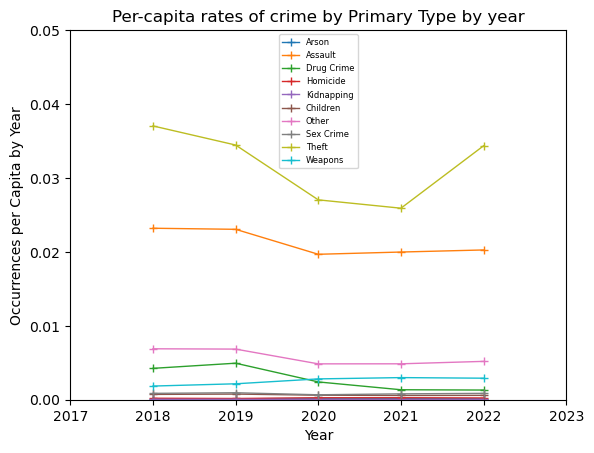

In [21]:
#time series for per-capita data by type (raw data)
years = crime_cleaned_df["Year"].unique()
plt.plot(years,arson_percap_years,marker="+",linewidth=1,label="Arson")
plt.plot(years,assault_percap_years,marker="+",linewidth=1,label="Assault")
plt.plot(years,drug_percap_years,marker="+",linewidth=1,label="Drug Crime")
plt.plot(years,homicide_percap_years,marker="+",linewidth=1,label="Homicide")
plt.plot(years,kidnap_percap_years,marker="+",linewidth=1,label="Kidnapping")
plt.plot(years,children_percap_years,marker="+",linewidth=1,label="Children")
plt.plot(years,other_minor_percap_years,marker="+",linewidth=1,label="Other")
plt.plot(years,sex_crime_percap_years,marker="+",linewidth=1,label="Sex Crime")
plt.plot(years,theft_percap_years,marker="+",linewidth=1,label="Theft")
plt.plot(years,weapon_percap_years,marker="+",linewidth=1,label="Weapons")
plt.xlim(2017,2023)
plt.ylim(0,0.05)
plt.title("Per-capita rates of crime by Primary Type by year")
plt.xlabel("Year")
plt.ylabel("Occurrences per Capita by Year")
plt.legend(fontsize = 6,loc='upper center')
plt.savefig("Images/per_capita_all_types.png")
plt.show()

In [22]:
#find 'per capita' counts by primary type by year (per 100k people)
arson_1k = clean_types_df["Arson"]/(clean_types_df["Population"]/1000)
assault_1k = clean_types_df["Assault"]/(clean_types_df["Population"]/1000)
drug_1k = clean_types_df["Drug Crime"]/(clean_types_df["Population"]/1000)
homicide_1k = clean_types_df["Homicide"]/(clean_types_df["Population"]/1000)
kidnap_1k = clean_types_df["Kidnapping"]/(clean_types_df["Population"]/1000)
non_crim_1k = clean_types_df["Non-criminal"]/(clean_types_df["Population"]/1000)
children_1k = clean_types_df["Children"]/(clean_types_df["Population"]/1000)
other_minor_1k = clean_types_df["Other"]/(clean_types_df["Population"]/1000)
sex_crime_1k = clean_types_df["Sex Crime"]/(clean_types_df["Population"]/1000)
theft_1k = clean_types_df["Theft"]/(clean_types_df["Population"]/1000)
weapon_1k = clean_types_df["Weapons"]/(clean_types_df["Population"]/1000)
totals_1k = clean_types_df["All Crimes"]/(clean_types_df["Population"]/1000)

In [23]:
#put the 'per 100k people' figures into a per capita DF
per_capita = {"Arson":arson_1k,"Assault":assault_1k,
               "Drug Crime":drug_1k,"Homicide":homicide_1k,
               "Kidnapping":kidnap_1k,
               "Non-criminal":non_crim_1k,
               "Children":children_1k,
               "Other":other_minor_1k,
               "Sex Crime":sex_crime_1k,
               "Theft":theft_1k,
               "Weapons":weapon_1k,
               "All Crimes":totals_1k}
per_capita_df = pd.DataFrame(per_capita)

#format some values
per_capita_df["Arson"] = per_capita_df["Arson"].map("{:,.2f}".format)
per_capita_df["Assault"] = per_capita_df["Assault"].map("{:,.2f}".format)
per_capita_df["Drug Crime"] = per_capita_df["Drug Crime"].map("{:,.2f}".format)
per_capita_df["Homicide"] = per_capita_df["Homicide"].map("{:,.2f}".format)
per_capita_df["Kidnapping"] = per_capita_df["Kidnapping"].map("{:,.2f}".format)
per_capita_df["Non-criminal"] = per_capita_df["Non-criminal"].map("{:,.2f}".format)
per_capita_df["Children"] = per_capita_df["Children"].map("{:,.2f}".format)
per_capita_df["Other"] = per_capita_df["Other"].map("{:,.2f}".format)
per_capita_df["Sex Crime"] = per_capita_df["Sex Crime"].map("{:,.2f}".format)
per_capita_df["Theft"] = per_capita_df["Theft"].map("{:,.2f}".format)
per_capita_df["Weapons"] = per_capita_df["Weapons"].map("{:,.2f}".format)
per_capita_df["All Crimes"] = per_capita_df["All Crimes"].map("{:,.2f}".format)

#save df as png image
dfi.export(per_capita_df,'Images/per_1k_df_all.png',table_conversion='matplotlib')

per_capita_df

,Arson,Assault,Drug Crime,Homicide,Kidnapping,Non-criminal,Children,Other,Sex Crime,Theft,Weapons,All Crimes
2018,0.12,23.20,4.24,0.20,0.06,0.00,0.72,6.89,0.86,37.04,1.85,86.56
2019,0.12,23.05,4.94,0.17,0.06,nan,0.76,6.85,0.94,34.45,2.16,84.42
2020,0.19,19.68,2.41,0.26,0.04,nan,0.61,4.85,0.67,27.04,2.82,68.02
2021,0.17,19.98,1.35,0.27,0.03,nan,0.57,4.86,0.79,25.91,2.99,66.14
2022,0.14,20.26,1.31,0.24,0.04,nan,0.59,5.19,0.86,34.36,2.91,76.04
Average,0.15,21.23,2.85,0.23,0.05,0.00,0.65,5.73,0.83,31.76,2.55,76.23


In [24]:
#convert the per-year figures by category into occurences per 1k people (excluding the average)
#first convert the population list to an array so you can perform operations on it
population = np.array(population)
arson_per_1k_years = years_types_df["Arson"]/(population/1000)
assault_per_1k_years = years_types_df["Assault"]/(population/1000)
drug_per_1k_years = years_types_df["Drug Crime"]/(population/1000)
homicide_per_1k_years = years_types_df["Homicide"]/(population/1000)
kidnap_per_1k_years = years_types_df["Kidnapping"]/(population/1000)
non_crim_per_1k_years = years_types_df["Non-criminal"]/(population/1000)
children_per_1k_years = years_types_df["Children"]/(population/1000)
other_minor_per_1k_years = years_types_df["Other"]/(population/1000)
sex_crime_per_1k_years = years_types_df["Sex Crime"]/(population/1000)
theft_per_1k_years = years_types_df["Theft"]/(population/1000)
weapon_per_1k_years = years_types_df["Weapons"]/(population/1000)


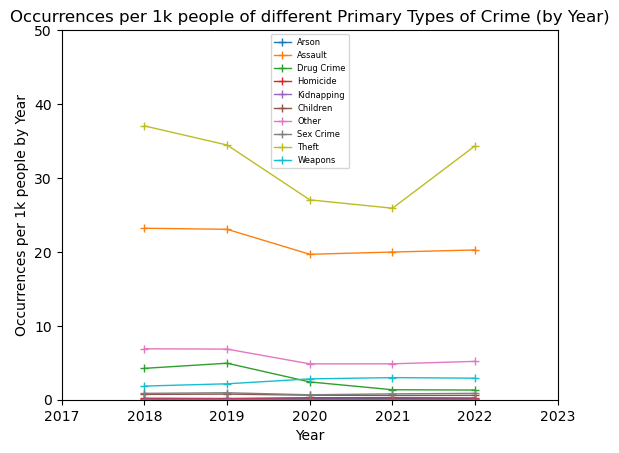

In [25]:
#add time series with the figures per 1k people by year (excluding the average)
years = crime_cleaned_df["Year"].unique()
plt.plot(years,arson_per_1k_years,marker="+",linewidth=1,label="Arson")
plt.plot(years,assault_per_1k_years,marker="+",linewidth=1,label="Assault")
plt.plot(years,drug_per_1k_years,marker="+",linewidth=1,label="Drug Crime")
plt.plot(years,homicide_per_1k_years,marker="+",linewidth=1,label="Homicide")
plt.plot(years,kidnap_per_1k_years,marker="+",linewidth=1,label="Kidnapping")
plt.plot(years,children_per_1k_years,marker="+",linewidth=1,label="Children")
plt.plot(years,other_minor_per_1k_years,marker="+",linewidth=1,label="Other")
plt.plot(years,sex_crime_per_1k_years,marker="+",linewidth=1,label="Sex Crime")
plt.plot(years,theft_per_1k_years,marker="+",linewidth=1,label="Theft")
plt.plot(years,weapon_per_1k_years,marker="+",linewidth=1,label="Weapons")
plt.xlim(2017,2023)
plt.ylim(0,50)
plt.title("Occurrences per 1k people of different Primary Types of Crime (by Year)")
plt.xlabel("Year")
plt.ylabel("Occurrences per 1k people by Year")
plt.legend(fontsize = 6,loc='upper center')
plt.savefig("Images/per_1k_all_types.png")
plt.show()

In [26]:
#add tables for heinous crimes
#total counts table
heinous_counts = {"Arson":arson,"Homicide":homicide,
                  "Kidnapping":kidnap,
                  "All Crimes":crime_counts}
heinous_table = pd.DataFrame(heinous_counts)

#save df as png image
dfi.export(heinous_table,'Images/type_count_df_heinous.png',table_conversion='matplotlib')

heinous_table

,Arson,Homicide,Kidnapping,All Crimes
2018,368.0,598.0,177.0,258966.0
2019,365.0,499.0,182.0,254518.0
2020,574.0,789.0,122.0,204271.0
2021,518.0,804.0,93.0,199060.0
2022,412.0,716.0,129.0,228855.0
Average,447.4,681.2,140.6,229134.0


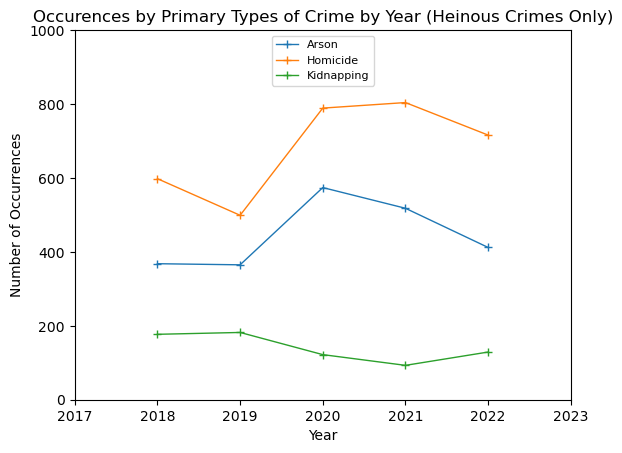

In [27]:
#add timeseries for just the heinous crimes
plt.plot(years,arson_count,marker="+",linewidth=1,label="Arson")
plt.plot(years,homicide_count,marker="+",linewidth=1,label="Homicide")
plt.plot(years,kidnap_count,marker="+",linewidth=1,label="Kidnapping")
plt.xlim(2017,2023)
plt.ylim(0,1000)
plt.title("Occurences by Primary Types of Crime by Year (Heinous Crimes Only)")
plt.xlabel("Year")
plt.ylabel("Number of Occurrences")
plt.legend(fontsize = 8,loc='upper center')
plt.savefig("Images/heinous_time_series.png")
plt.show()

In [28]:
#percentage table
heinous_percent = {"Arson":arson_percent,"Homicide":homicide_percent,
                  "Kidnapping":kidnap_percent,}
heinous_percent_table = pd.DataFrame(heinous_percent)

#format the values
heinous_percent_table["Arson"] = heinous_percent_table["Arson"].map("{:,.4f}%".format)
heinous_percent_table["Homicide"] = heinous_percent_table["Homicide"].map("{:,.4f}%".format)
heinous_percent_table["Kidnapping"] = heinous_percent_table["Kidnapping"].map("{:,.4f}%".format)

#save df as png image
dfi.export(heinous_percent_table,'Images/percent_df_heinous.png',table_conversion='matplotlib')

heinous_percent_table

,Arson,Homicide,Kidnapping
2018,0.1421%,0.2309%,0.0683%
2019,0.1434%,0.1961%,0.0715%
2020,0.2810%,0.3863%,0.0597%
2021,0.2602%,0.4039%,0.0467%
2022,0.1800%,0.3129%,0.0564%
Totals,0.1953%,0.2973%,0.0614%


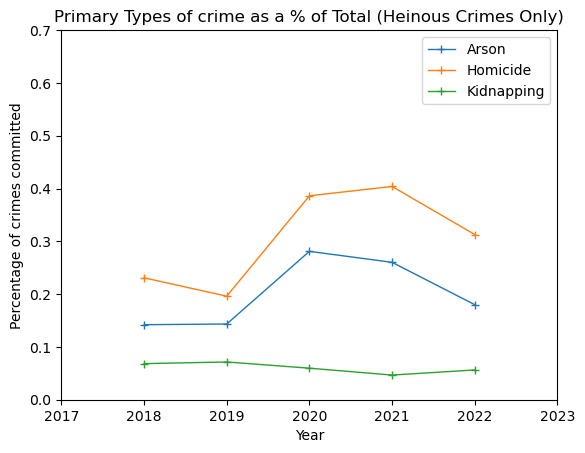

In [29]:
#add time series for the percentages by category for heinous crimes
plt.plot(years,arson_percent_years,marker="+",linewidth=1,label="Arson")
plt.plot(years,homicide_percent_years,marker="+",linewidth=1,label="Homicide")
plt.plot(years,kidnap_percent_years,marker="+",linewidth=1,label="Kidnapping")
plt.xlim(2017,2023)
plt.ylim(0,0.7)
plt.title("Primary Types of crime as a % of Total (Heinous Crimes Only)")
plt.xlabel("Year")
plt.ylabel("Percentage of crimes committed")
plt.legend(fontsize = 10,loc='best')
plt.savefig("Images/heinous_percent.png")
plt.show()

In [30]:
#create a table for the raw per-capita data for heinous crimes
heinous_per_cap = {"Arson":arson_per_capita,"Homicide":homicide_per_capita,
                  "Kidnapping":kidnap_per_capita,
                  "All Crimes":totals_per_capita}
heinous_per_cap_table = pd.DataFrame(heinous_per_cap)

#save df as png image
dfi.export(heinous_per_cap_table,'Images/per_capita_df_heinous.png',table_conversion='matplotlib')

heinous_per_cap_table

,Arson,Homicide,Kidnapping,All Crimes
2018,0.000123,0.000200,0.000059,0.086561
2019,0.000121,0.000166,0.000060,0.084422
2020,0.000191,0.000263,0.000041,0.068019
2021,0.000172,0.000267,0.000031,0.066141
2022,0.000137,0.000238,0.000043,0.076041
Average,0.000149,0.000227,0.000047,0.076231


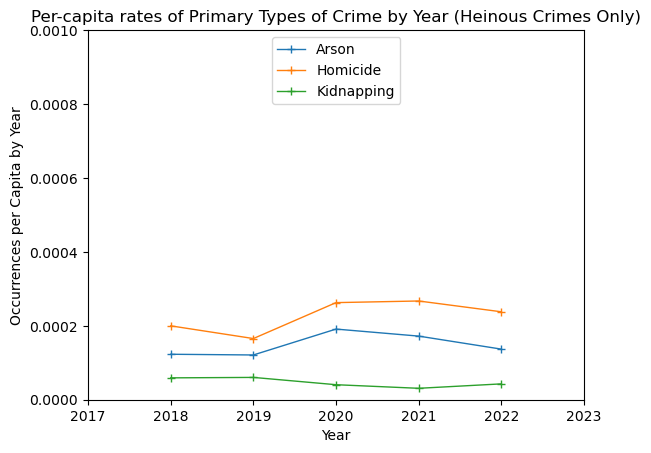

In [31]:
#add a time series for per-capita data for heinous crimes only
plt.plot(years,arson_percap_years,marker="+",linewidth=1,label="Arson")
plt.plot(years,homicide_percap_years,marker="+",linewidth=1,label="Homicide")
plt.plot(years,kidnap_percap_years,marker="+",linewidth=1,label="Kidnapping")
plt.xlim(2017,2023)
plt.ylim(0,0.001)
plt.title("Per-capita rates of Primary Types of Crime by Year (Heinous Crimes Only)")
plt.xlabel("Year")
plt.ylabel("Occurrences per Capita by Year")
plt.legend(fontsize = 10,loc='upper center')
plt.savefig("Images/per_capita_heinous.png")
plt.show()

In [32]:
#create table for the per-capita (per 1k people) for heinous crimes
heinous_per_1k = {"Arson":arson_1k,"Homicide":homicide_1k,
                  "Kidnapping":kidnap_1k,
                  "All Crimes":totals_1k}
heinous_per_1k_table = pd.DataFrame(heinous_per_1k)

#save df as png image
dfi.export(heinous_per_1k_table,'Images/per_1k_df_heinous.png',table_conversion='matplotlib')

heinous_per_1k_table

,Arson,Homicide,Kidnapping,All Crimes
2018,0.123007,0.199886,0.059164,86.561429
2019,0.121068,0.165515,0.060368,84.422063
2020,0.191133,0.262725,0.040624,68.019027
2021,0.172114,0.267142,0.030901,66.140823
2022,0.136893,0.237902,0.042862,76.040681
Average,0.148846,0.226629,0.046776,76.230859


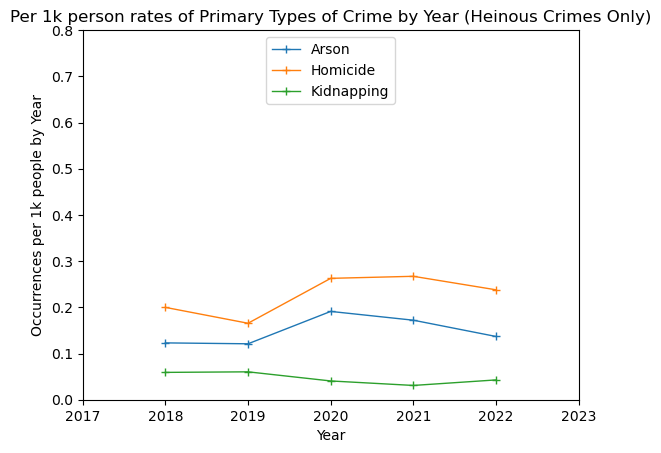

In [33]:
#add a time series for heinous crimes committed per 1k people by year
plt.plot(years,arson_per_1k_years,marker="+",linewidth=1,label="Arson")
plt.plot(years,homicide_per_1k_years,marker="+",linewidth=1,label="Homicide")
plt.plot(years,kidnap_per_1k_years,marker="+",linewidth=1,label="Kidnapping")
plt.xlim(2017,2023)
plt.ylim(0,0.8)
plt.title("Per 1k person rates of Primary Types of Crime by Year (Heinous Crimes Only)")
plt.xlabel("Year")
plt.ylabel("Occurrences per 1k people by Year")
plt.legend(fontsize = 10,loc='upper center')
plt.savefig("Images/per_1k_heinous.png")
plt.show()

In [60]:
#define averages for the heinous crime categories (and all other categories) across the sample
all_crimes = crime_cleaned_df["Primary Type"].count()
arson_total = total_arson
homicide_total = total_homicide
kidnap_total = total_kidnap
heinous_total = arson_total+homicide_total+kidnap_total
others_total = all_crimes-heinous_total
heinous_avg = (heinous_total/all_crimes)*100
others_avg = (others_total/all_crimes)*100
others_avg

99.44608831513438

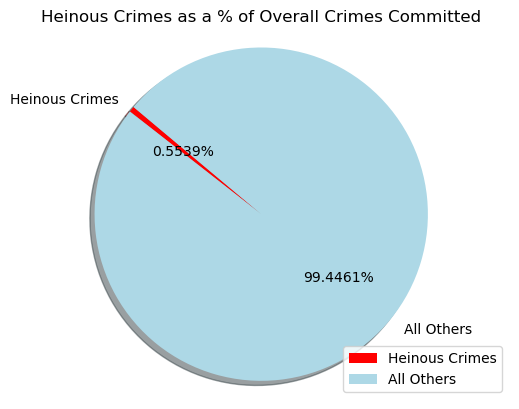

In [62]:
#Create a pie chart comparing the 3 categories of heinous crimes to all the others
crime_types = ["Heinous Crimes","All Others"]
crime_rates = [heinous_avg, others_avg]
colors = ["red","lightblue"]
explode = (0,0)

plt.pie(crime_rates,explode=explode,labels=crime_types,colors=colors,
        autopct="%1.4f%%", shadow=True, startangle=140)

# Create axes which are equal so we have a perfect circle
plt.title("Heinous Crimes as a % of Overall Crimes Committed")
plt.axis('equal')
#Add a legend
plt.legend(crime_types,loc='lower right')
#save file to resources folder
plt.savefig("Images/heinous_pie.png")
plt.show()


#   4) How common is extremely violent crime? END